   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4


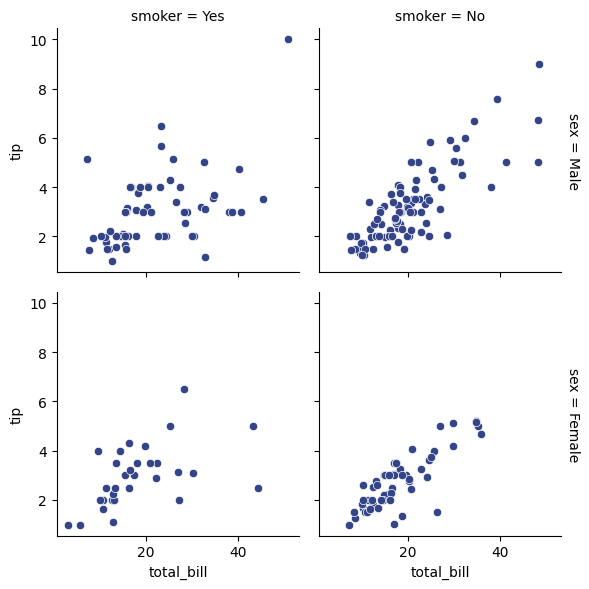

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tips = sns.load_dataset('tips')
print(tips.head())

# attend = sns.load_dataset("attention").query("subject <= 12")
# print(attend.head())    
grid = sns.FacetGrid(tips, col="smoker", row="sex",
                    #  col_wrap=4, 
                     height=3, # height of entire figure
                    #  ylim=(0, 10),
                     margin_titles=True)
grid.map(sns.scatterplot, "total_bill", "tip", color="#334488")
grid.figure.subplots_adjust(wspace=0.01, hspace=0.01)
grid.figure.tight_layout()

plt.show()

In [2]:
data_file = r"R:\H3D-sensor-test\mask_sweep_2024-06-26_ALL_DATA\mask_sweep_2024-06-26.csv"
# add parent directory to path
import sys
import os
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
sys.path.append(r"C:\Users\10552\OneDrive - Redlen Technologies\Code\spectrum-analyzer")

from data_handling_modules import TransformDf, ExtractModule, ExtractModuleStreamlit

bin_peak_input = 95
peak_halfwidth_input = 25

def parse_data(file_path_input):
    EM = ExtractModule(file_path_input)
    print(f"Number of lines in data file: {EM.count_lines()}")
    extracted_df_list = EM.extract_all_modules2df()

    TD = TransformDf()
    df_transformed_list = TD.transform_all_df(extracted_df_list)

    if bin_peak_input is not None and peak_halfwidth_input is not None:
        peak_halfwidth = peak_halfwidth_input
        df_transformed_list = TD.add_peak_counts_all(bin_peak_input, peak_halfwidth)

    x_positions = EM.extract_metadata_list(EM.csv_file, "stage_x_mm:")
    y_positions = EM.extract_metadata_list(EM.csv_file, "stage_y_mm:")
    heights = EM.extract_metadata_list(EM.csv_file, "height:")

    return (EM.number_of_modules, EM.n_pixels_x, EM.n_pixels_y, 
            x_positions, y_positions, heights, df_transformed_list)

N_MODULES, N_PIXELS_X, N_PIXELS_Y, x_positions, y_positions, heights, df_transformed_list = parse_data(data_file)

Number of lines in data file: 1367


In [12]:
df2 = df_transformed_list[2]

In [13]:
df2.head()

x_index  y_index  pixel_id  \
1        1        1         1   
2        1        2         2   
3        1        3         3   
4        1        4         4   
5        1        5         5   

                                          array_bins  total_count  \
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           14   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           10   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            9   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            7   
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            2   

   total_counts_norm  is_edge  peak_count  non_peak_count  
1              0.033     True          14               0  
2              0.024     True           9               1  
3              0.021     True           6               3  
4              0.017     True           7               0  
5              0.005     True           2               0

In [46]:
x_index = 6
y_index = 6
df_cropped = df2[(df2["x_index"]<=x_index) & (df2["y_index"]<=y_index)]


In [47]:
df_cropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 1 to 61
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x_index            36 non-null     int32  
 1   y_index            36 non-null     int32  
 2   pixel_id           36 non-null     int64  
 3   array_bins         36 non-null     object 
 4   total_count        36 non-null     int32  
 5   total_counts_norm  36 non-null     float64
 6   is_edge            36 non-null     bool   
 7   peak_count         36 non-null     int64  
 8   non_peak_count     36 non-null     int64  
dtypes: bool(1), float64(1), int32(3), int64(3), object(1)
memory usage: 2.1+ KB


In [48]:
for x in range(1, x_index+1):
    for y in range(1, y_index+1):
        pixel_df = df_cropped[(df_cropped["x_index"]==x) & 
                                (df_cropped["y_index"]==y)]
        array_bin = pixel_df["array_bins"].values[0]
        x_bin = np.arange(0, len(array_bin))
        # plt.plot(x_bin, array_bin, label=f"x={x}, y={y}")
        # plt.legend()
        
    

In [131]:
# df_plot = df2.copy()
def spectrum_grid_plot(
    df_plot, min_range=80, max_range=110, vline_pos=95, hline_pos=12
):
    grid = sns.FacetGrid(
        df_plot,
        row="y_index",
        col="x_index",
        sharex=True,
        sharey=True,
        despine=False,
        #  col_wrap=4,
        height=2,  # height of each subplot
        #  ylim=(0, 10), # set y-axis limits
        margin_titles=True,
    )

    # min_range, max_range = 80, 110
    for (row_val, col_val), ax in grid.axes_dict.items():
        x_index, y_index = col_val, row_val
        # print(f"x={x_index}, y={y_index}")
        pixel_df = df_plot[
            (df_plot["x_index"] == x_index) & (df_plot["y_index"] == y_index)
        ]
        array_bin = pixel_df["array_bins"].values[0]
        peak_count = pixel_df["peak_count"].values[0]
        x_bin = np.arange(min_range, max_range)
        ax.plot(x_bin, array_bin[min_range:max_range], lw=4, color="b", alpha=0.8)
        
        max_count = max(array_bin[min_range:max_range])
        peak_bin = np.argmax(array_bin[min_range:max_range]) + min_range
        ax.text(
            peak_bin,
            max_count + 4,
            f"{peak_bin}",
            fontsize=18,
            color="r",
            ha="center",
            va="bottom",
        )
        ax.text(x=max_range, y=45, s=f"{peak_count}", fontsize=18, color="b",
                va="top", ha="right")
        ax.plot(peak_bin, max_count, marker="+", color="r", markersize=12)
        
        # plot a vertical line at x=95
        ax.axvline(x=vline_pos, color="r", linestyle="-.", alpha=0.5)
        ax.axhline(y=hline_pos, color="g", linestyle="-.", alpha=0.5)
        ax.set_xlabel(f"X = {x_index}")
        ax.set_ylabel(f"Y = {y_index}")
        # ax.set_title(f"({x_index}, {y_index})")
        ax.grid(True, alpha=0.3, linestyle="--")
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)


    grid.figure.subplots_adjust(wspace=0.05, hspace=0.1)
    grid.set_titles(col_template="{col_name}", row_template="{row_name}")
    # grid.set(xticks=[80, 90, 100])
    # grid.refline(y=12, linestyle="--", linewidth=1, color="g", alpha=0.5)
    # grid.refline(x=95, linestyle="--", linewidth=1, color="r", alpha=0.5)

    return grid


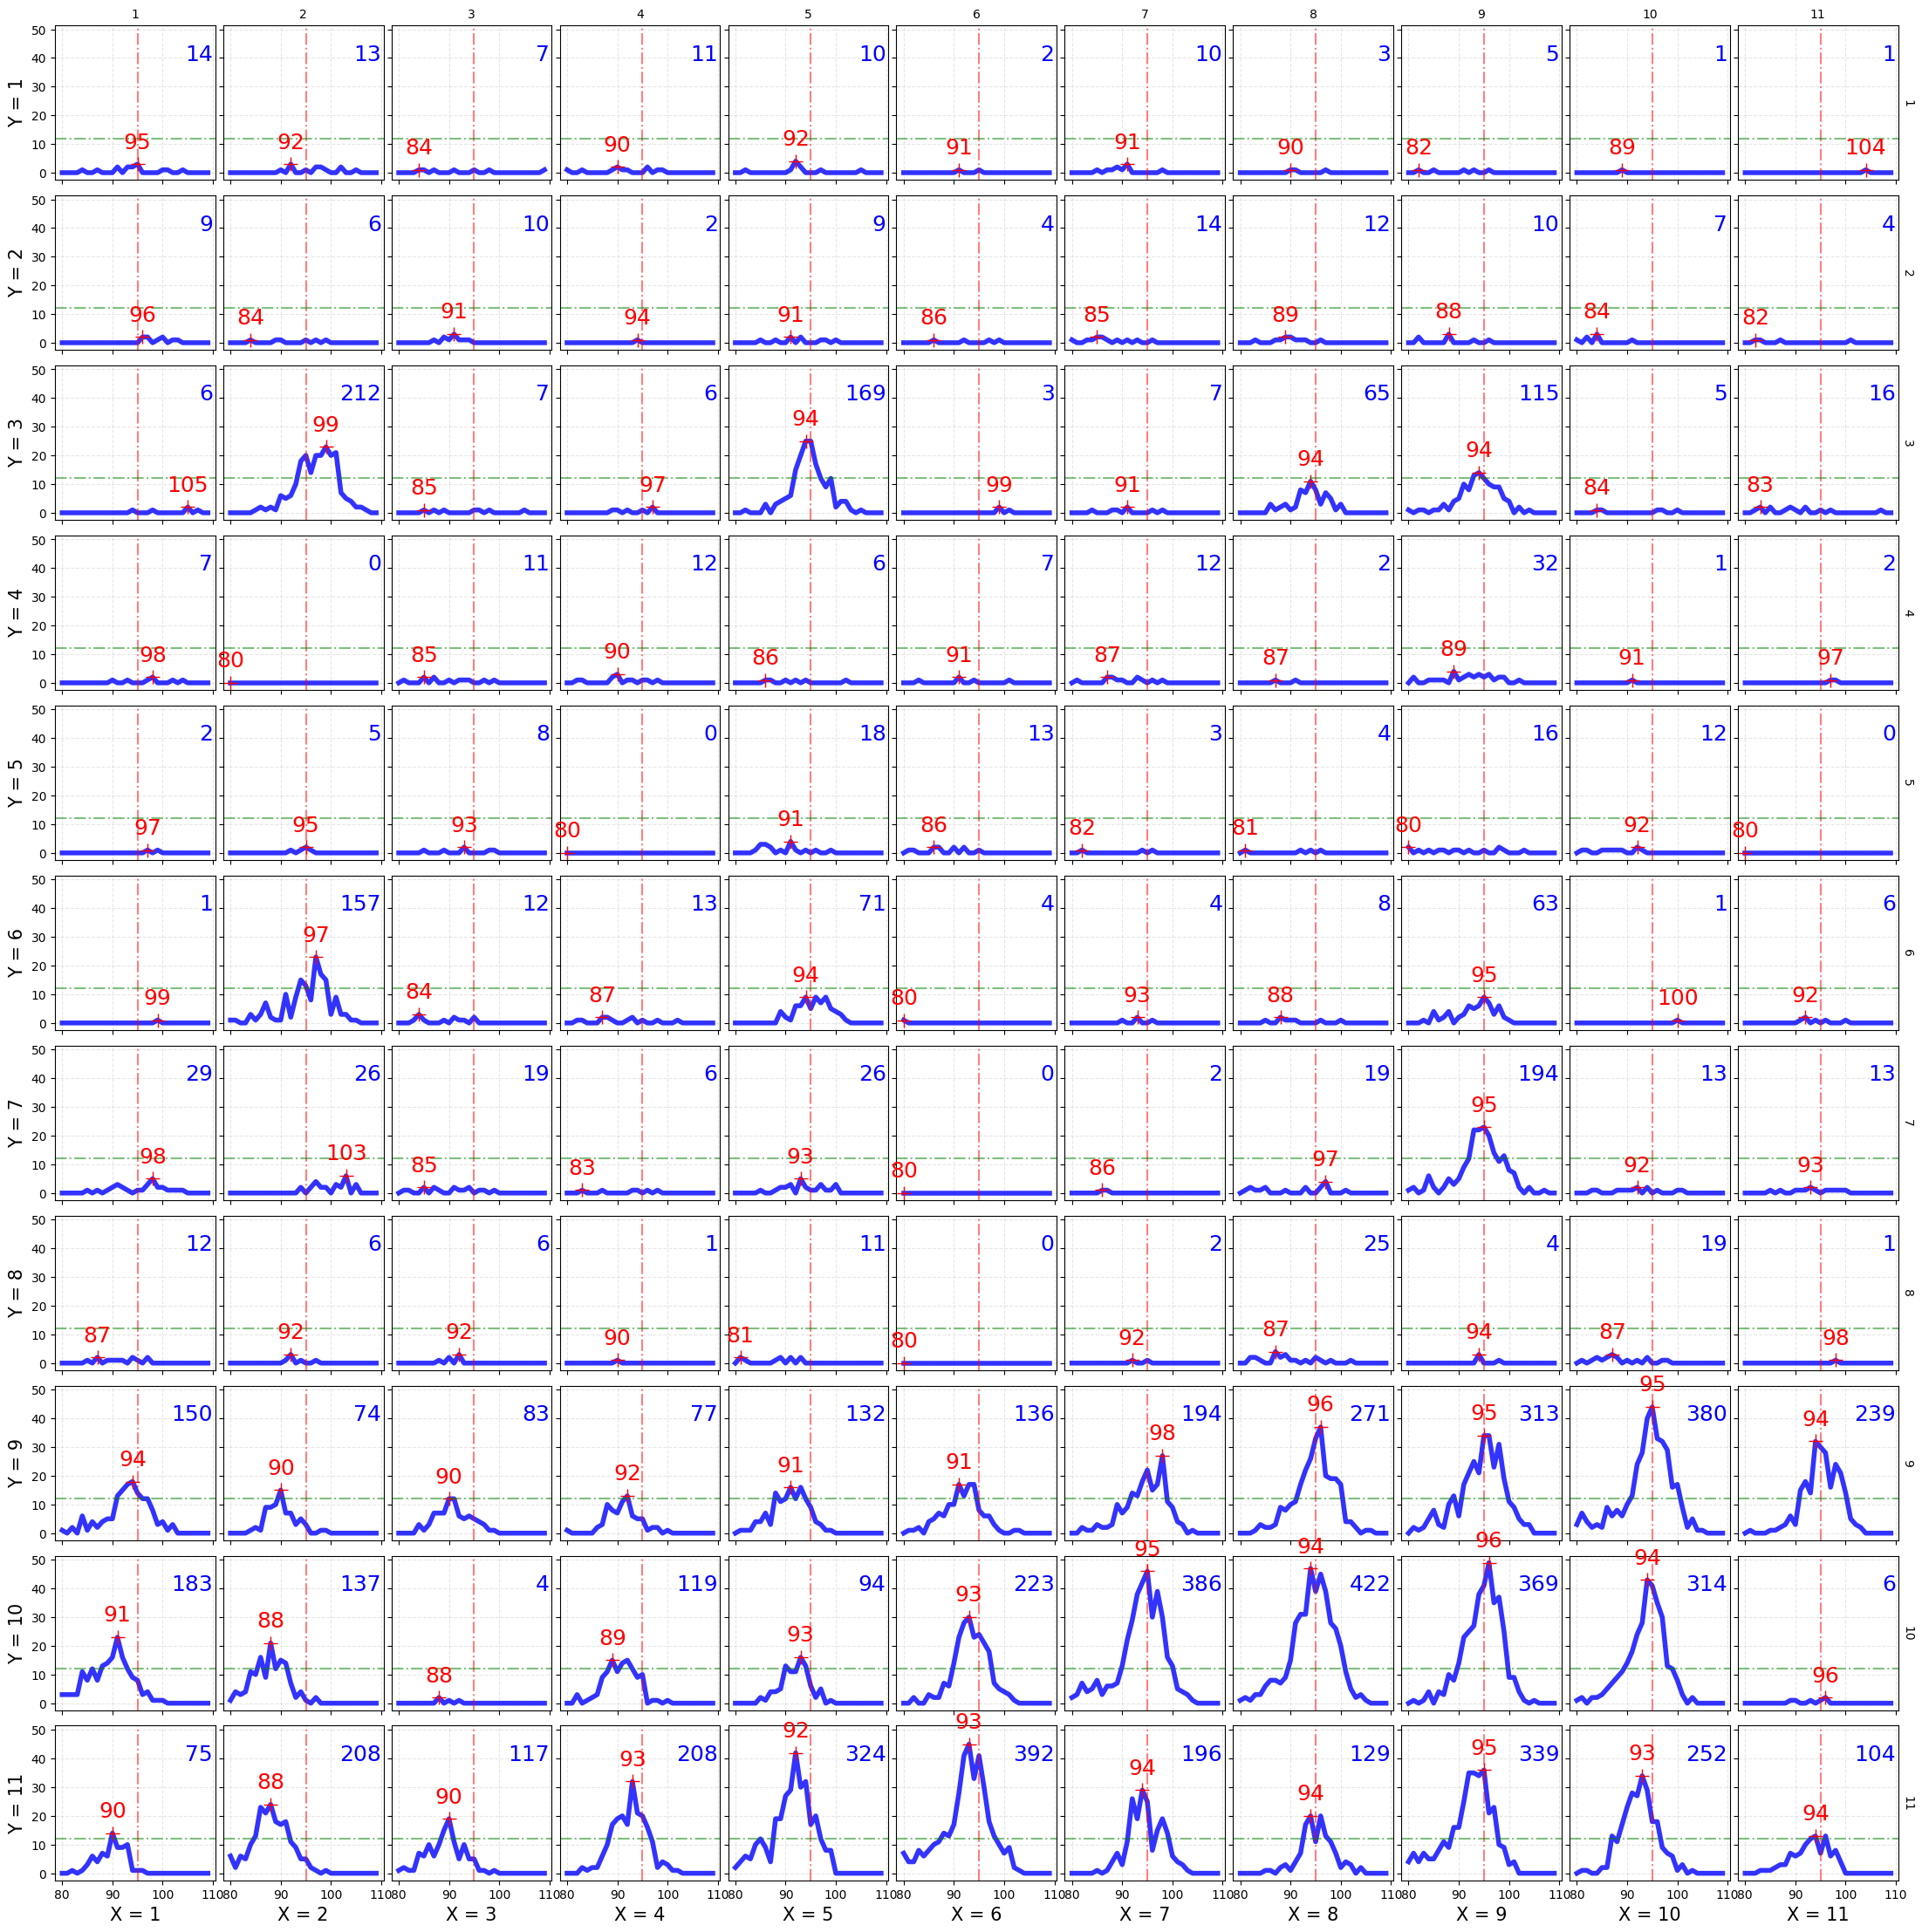

In [132]:
# df_plot = df_cropped.copy()
df_plot = df2.copy()
grid = spectrum_grid_plot(df_plot, min_range=80, max_range=110, vline_pos=95, hline_pos=12)
# grid.figure.title("Spectrum Grid Plot", fontsize=16)
plt.show()

In [139]:
# save grid plot to file
save_folder = r"C:\Users\10552\OneDrive - Redlen Technologies\Code\spectrum-analyzer\grid_plots"

output_file = os.path.join(save_folder, "grid_plot.png")
grid.savefig(output_file, dpi=80)

In [140]:
len(df_transformed_list)

10

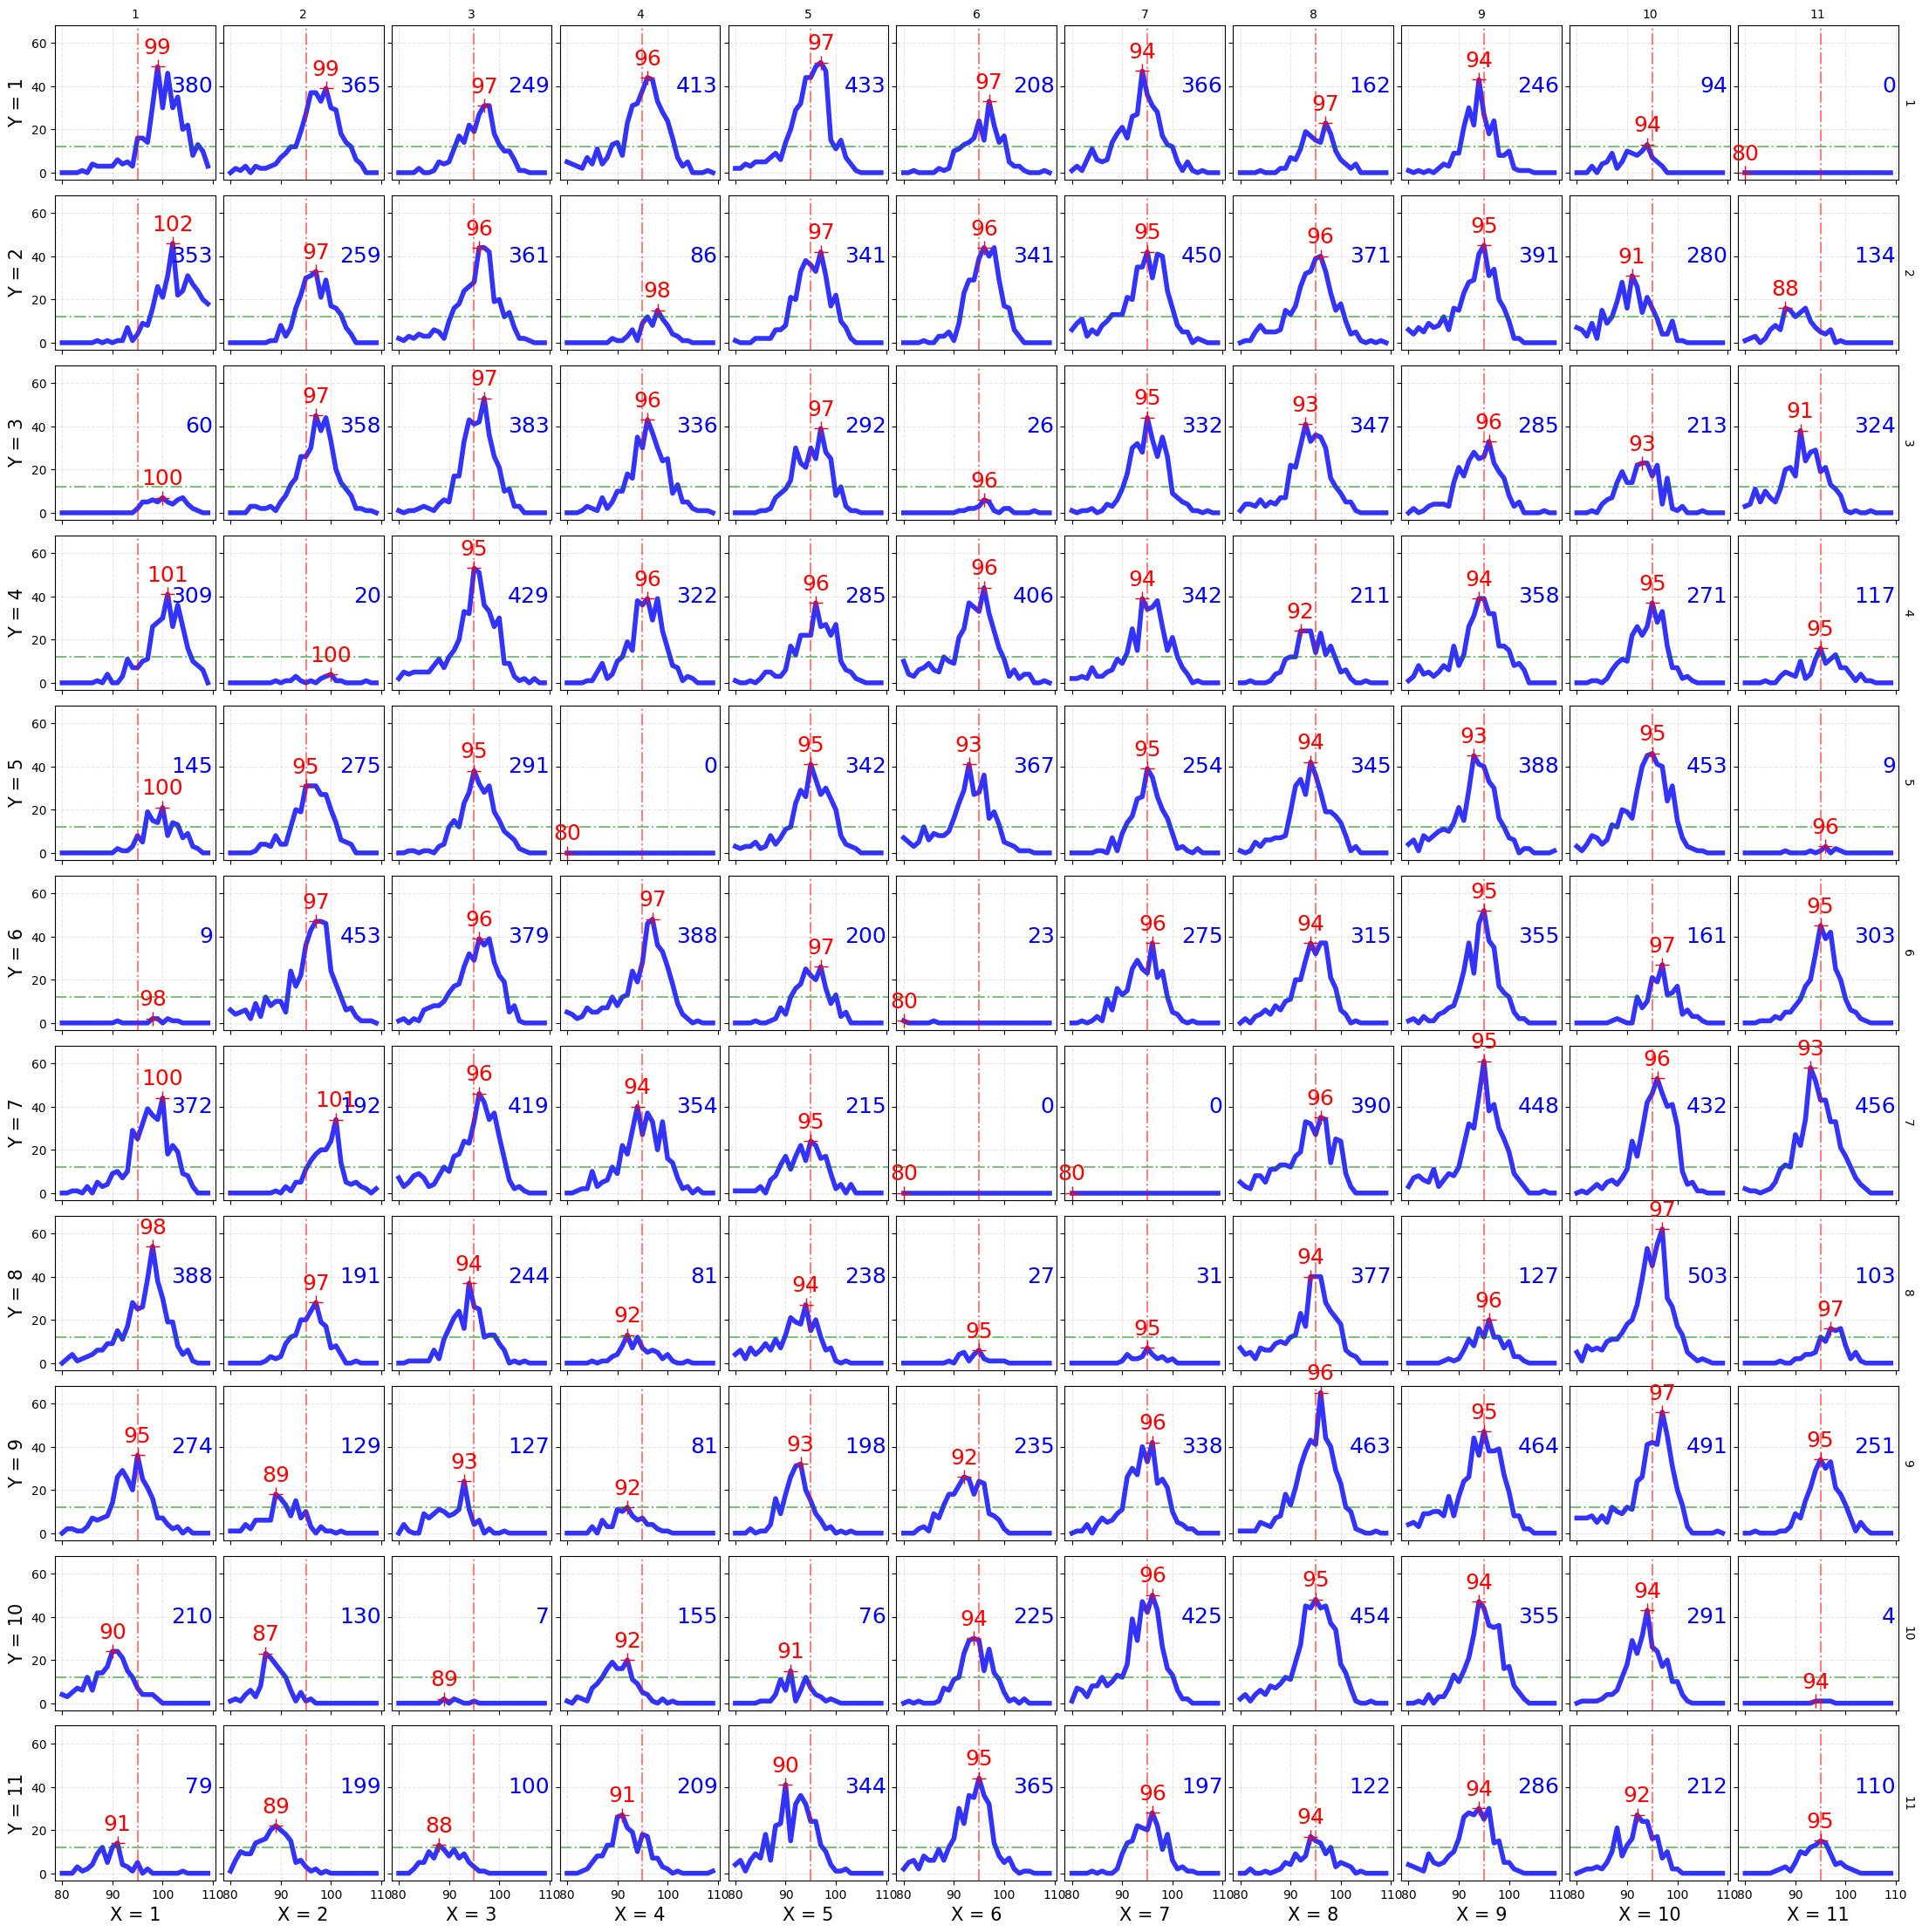

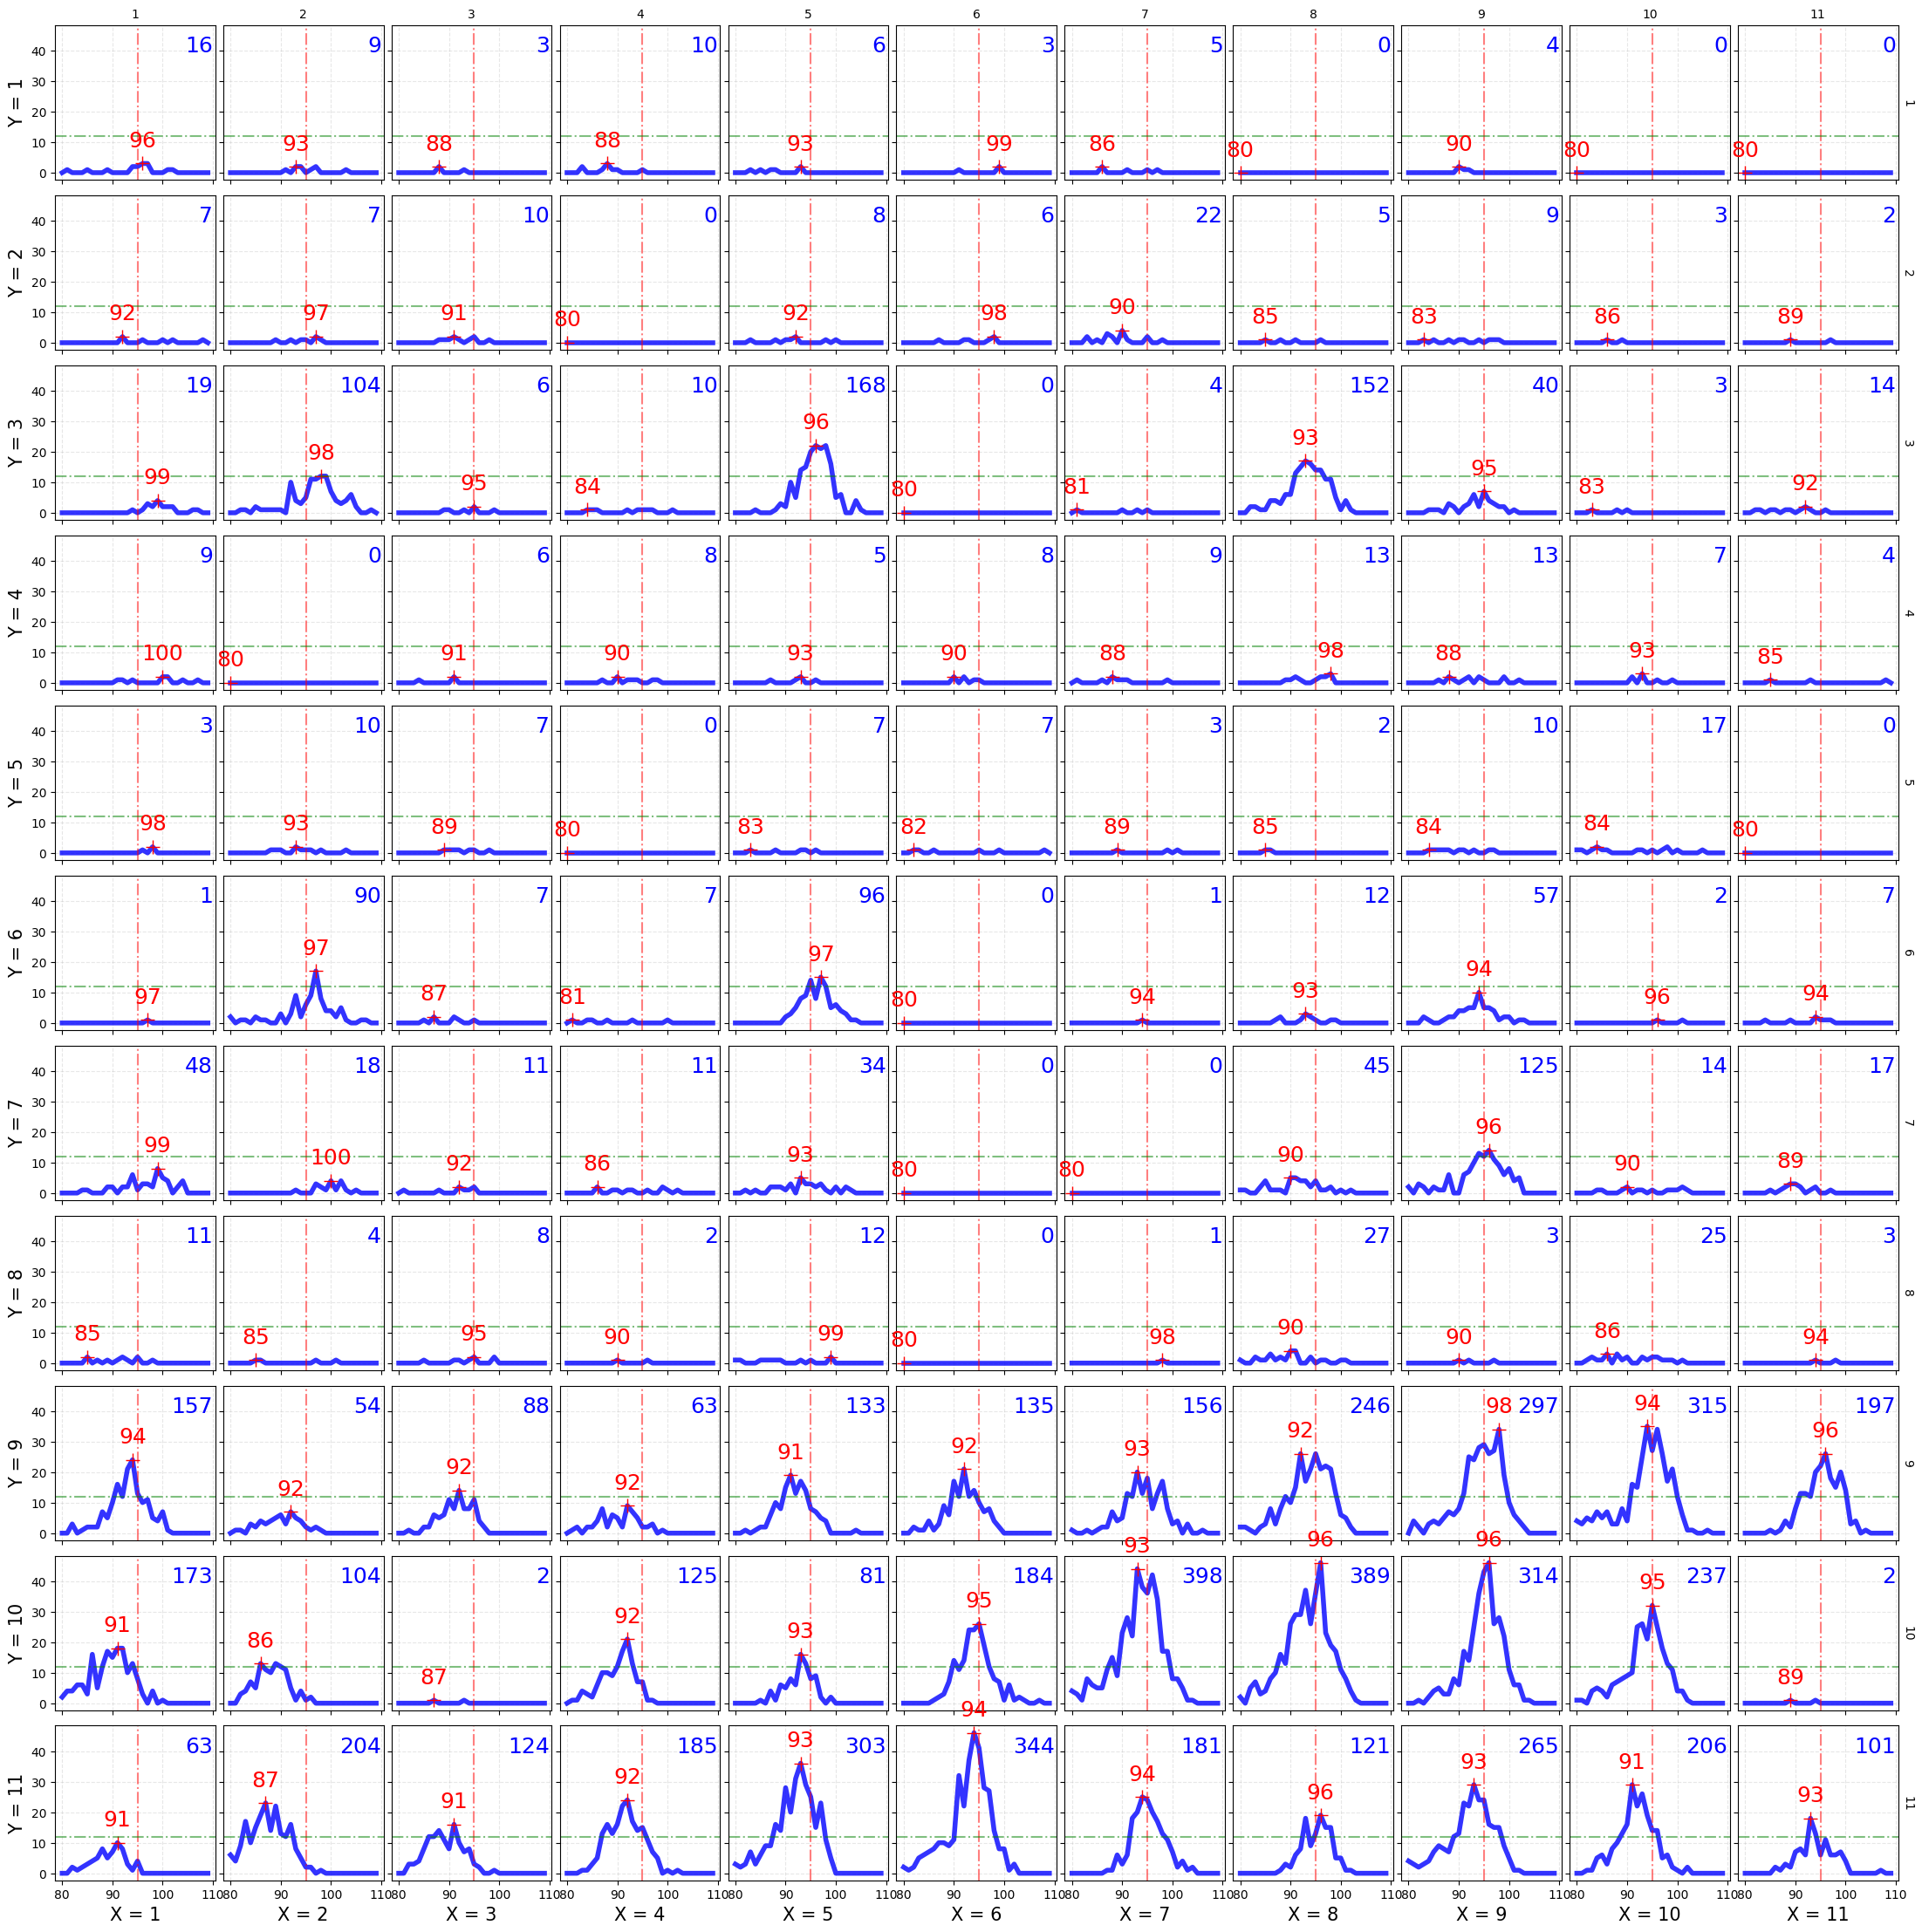

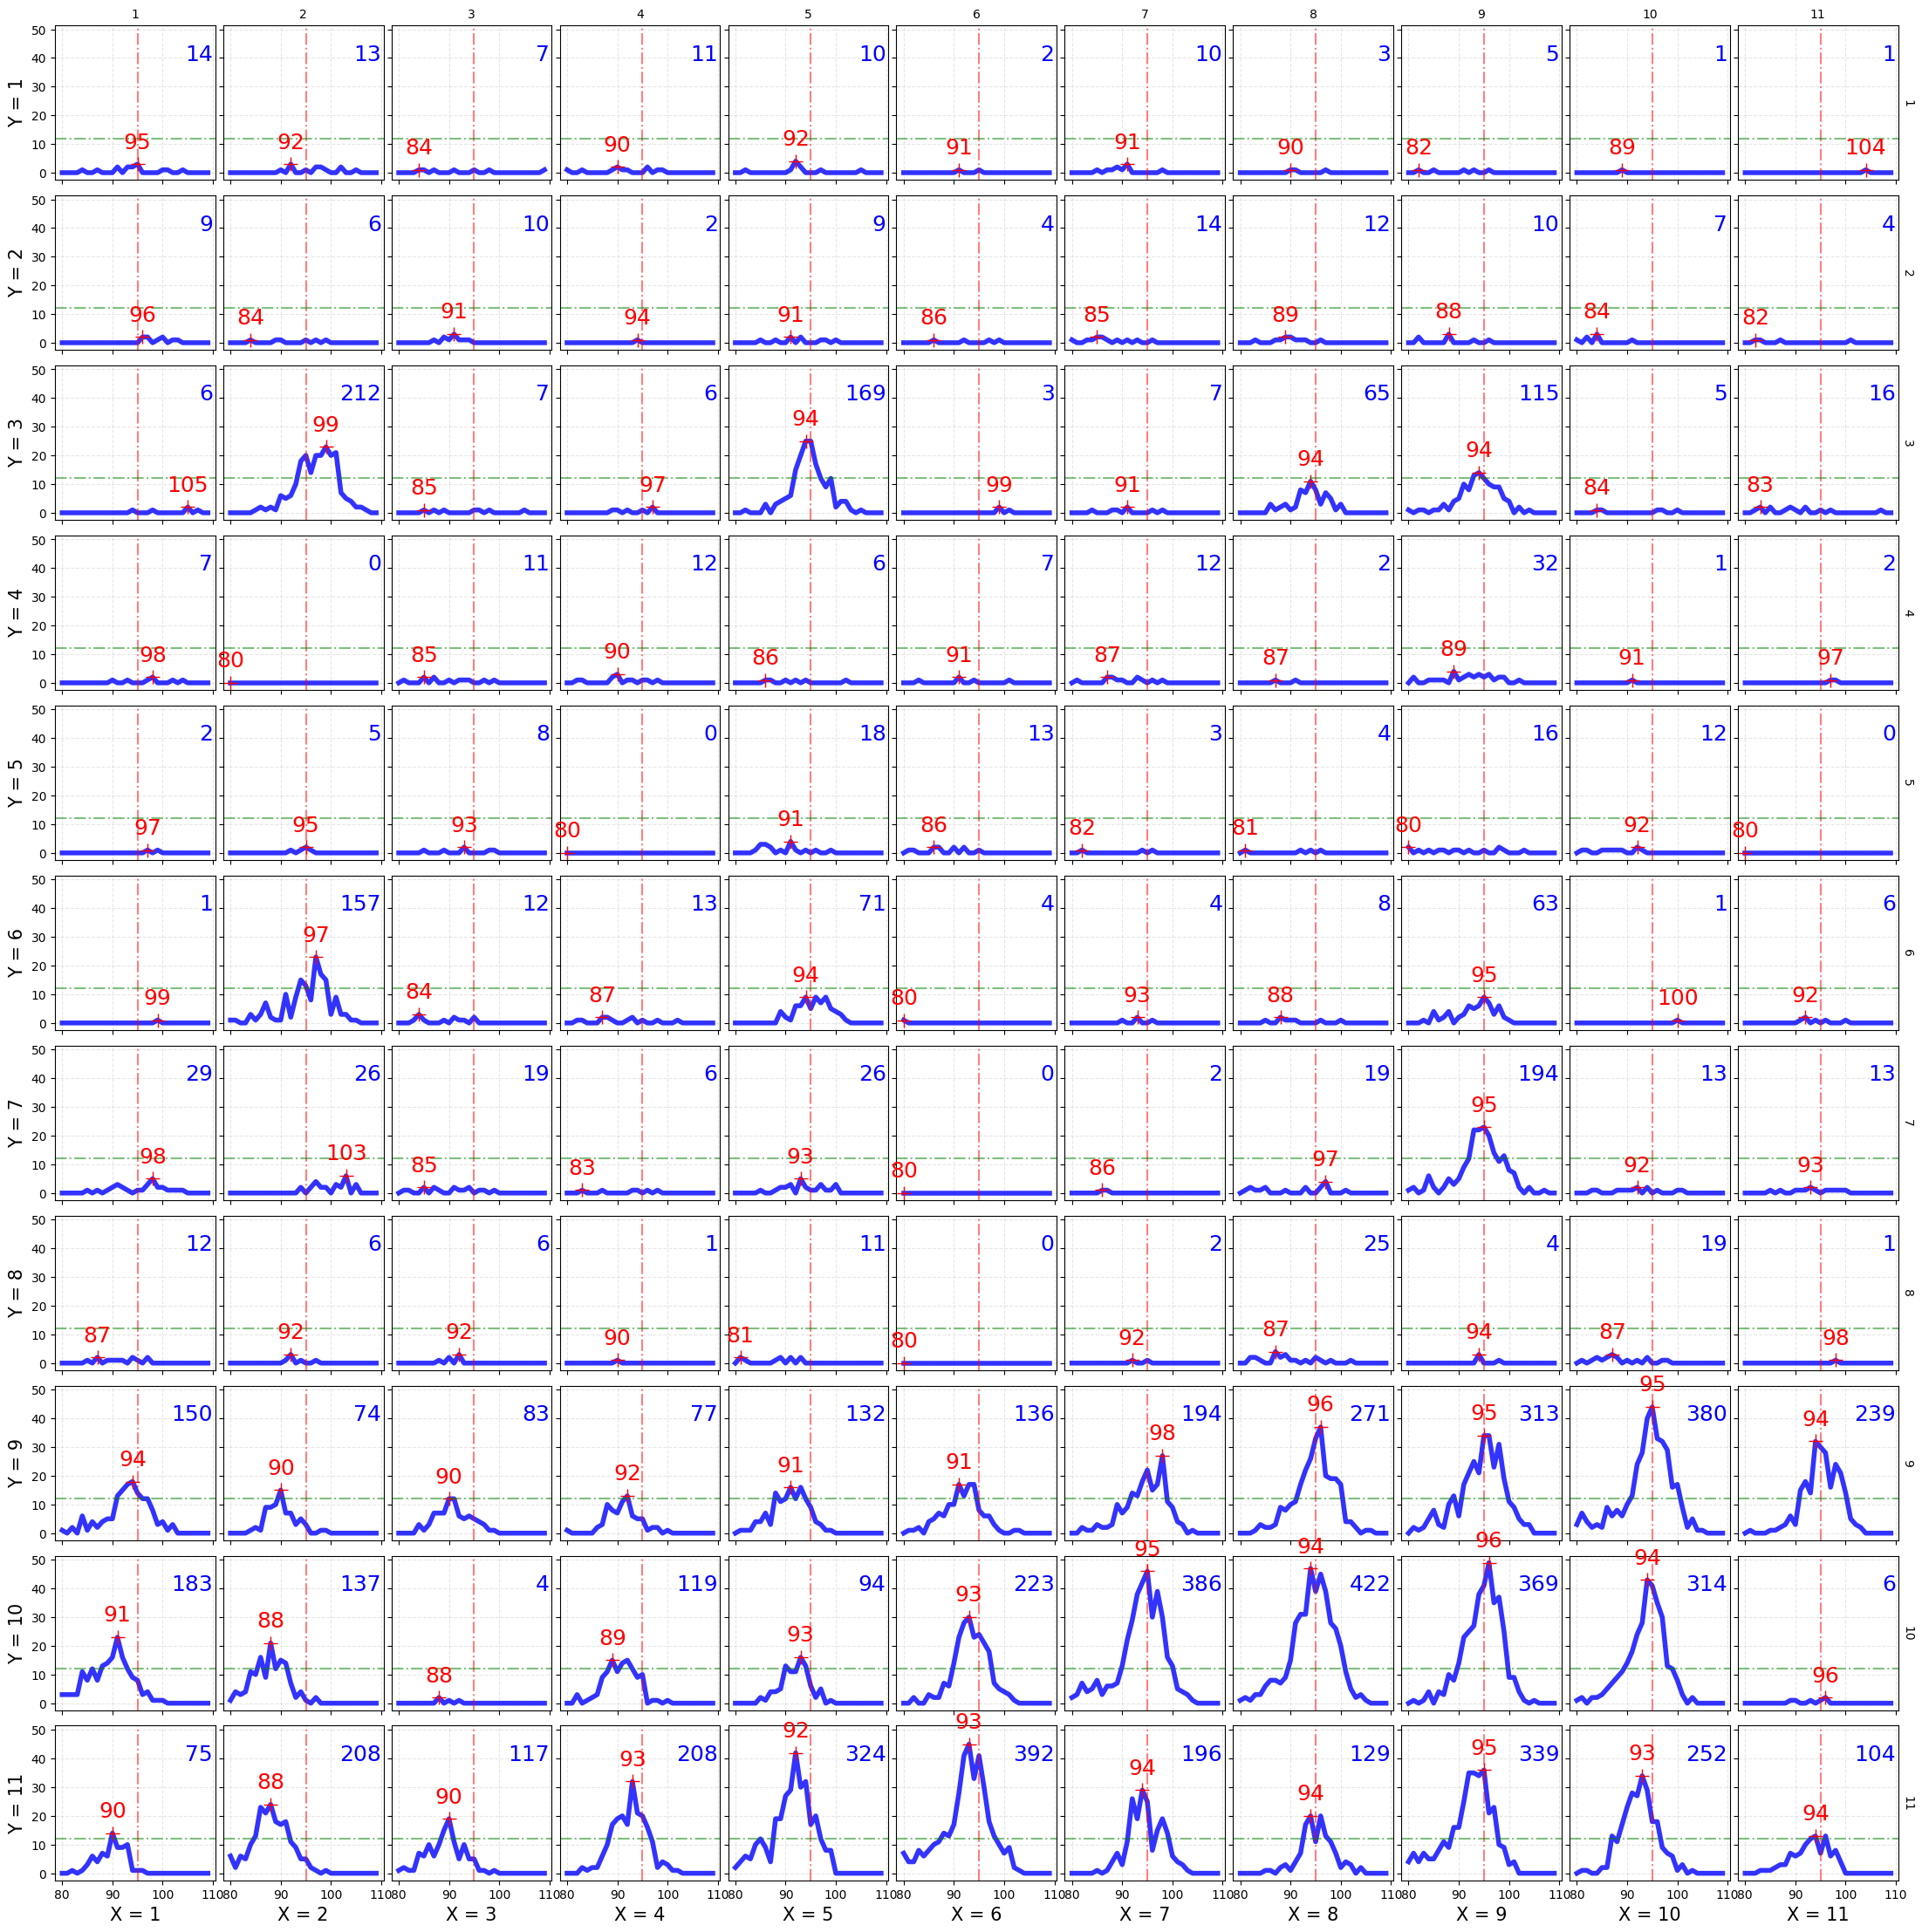

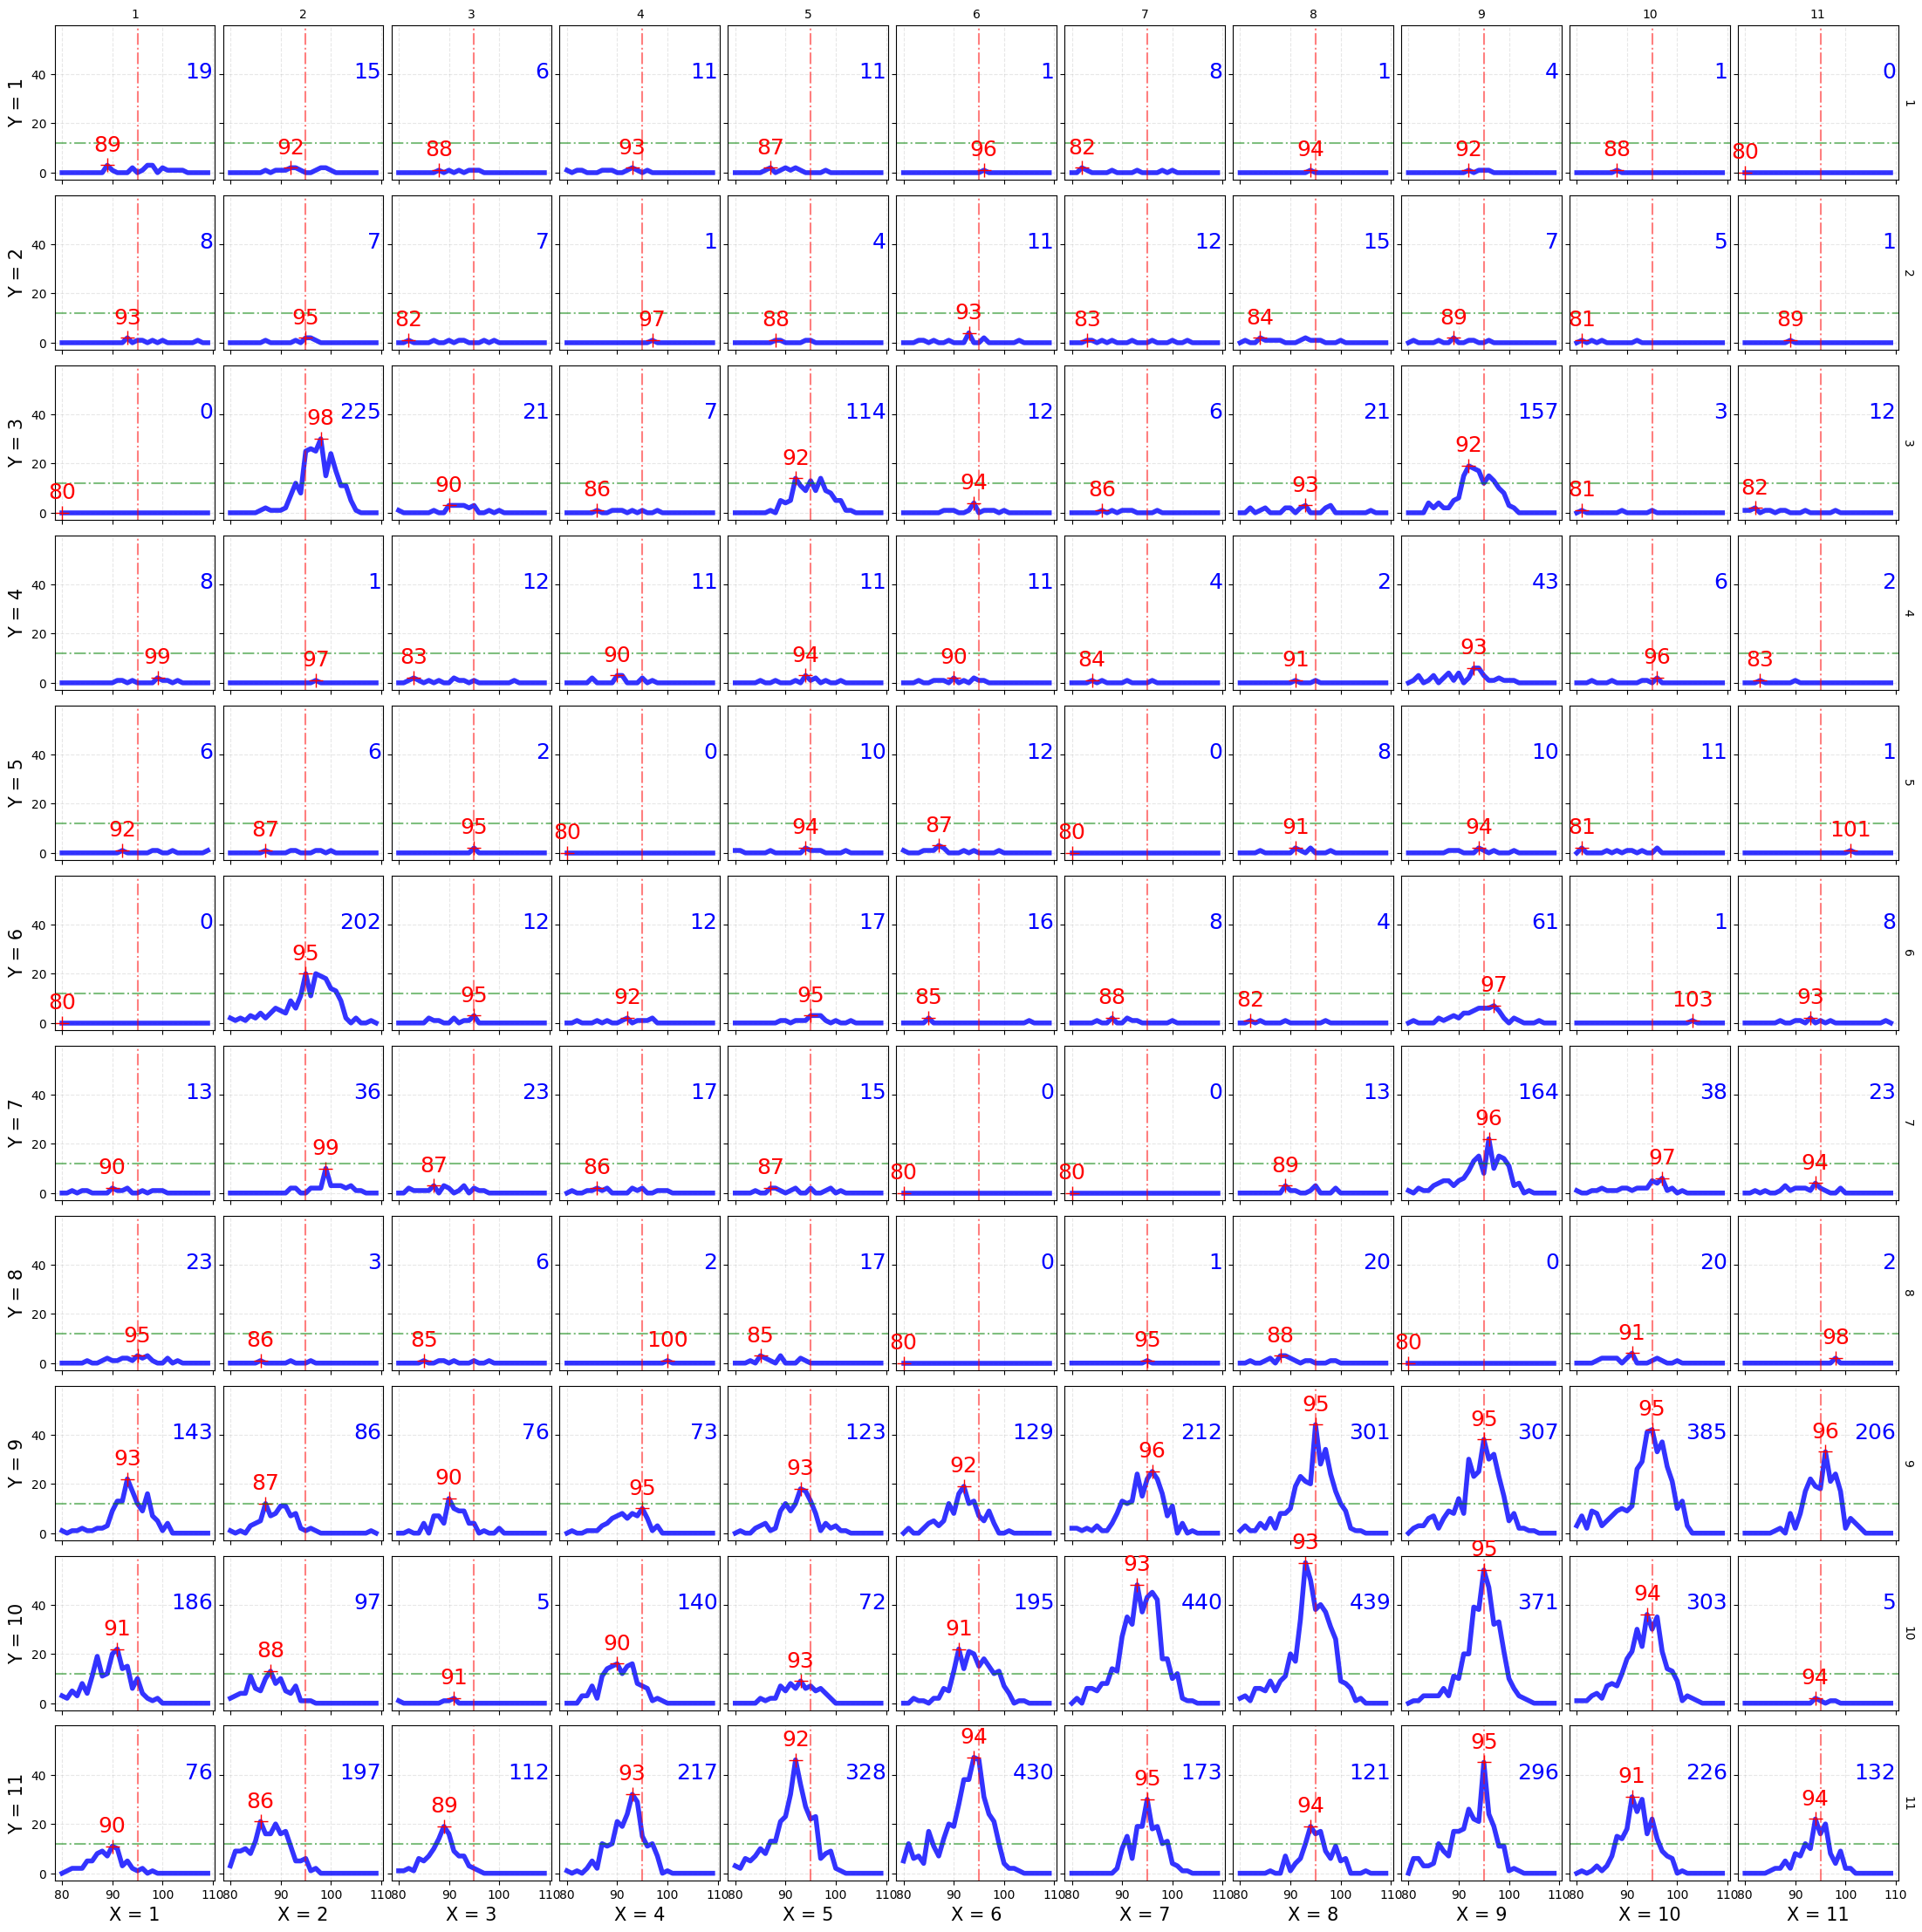

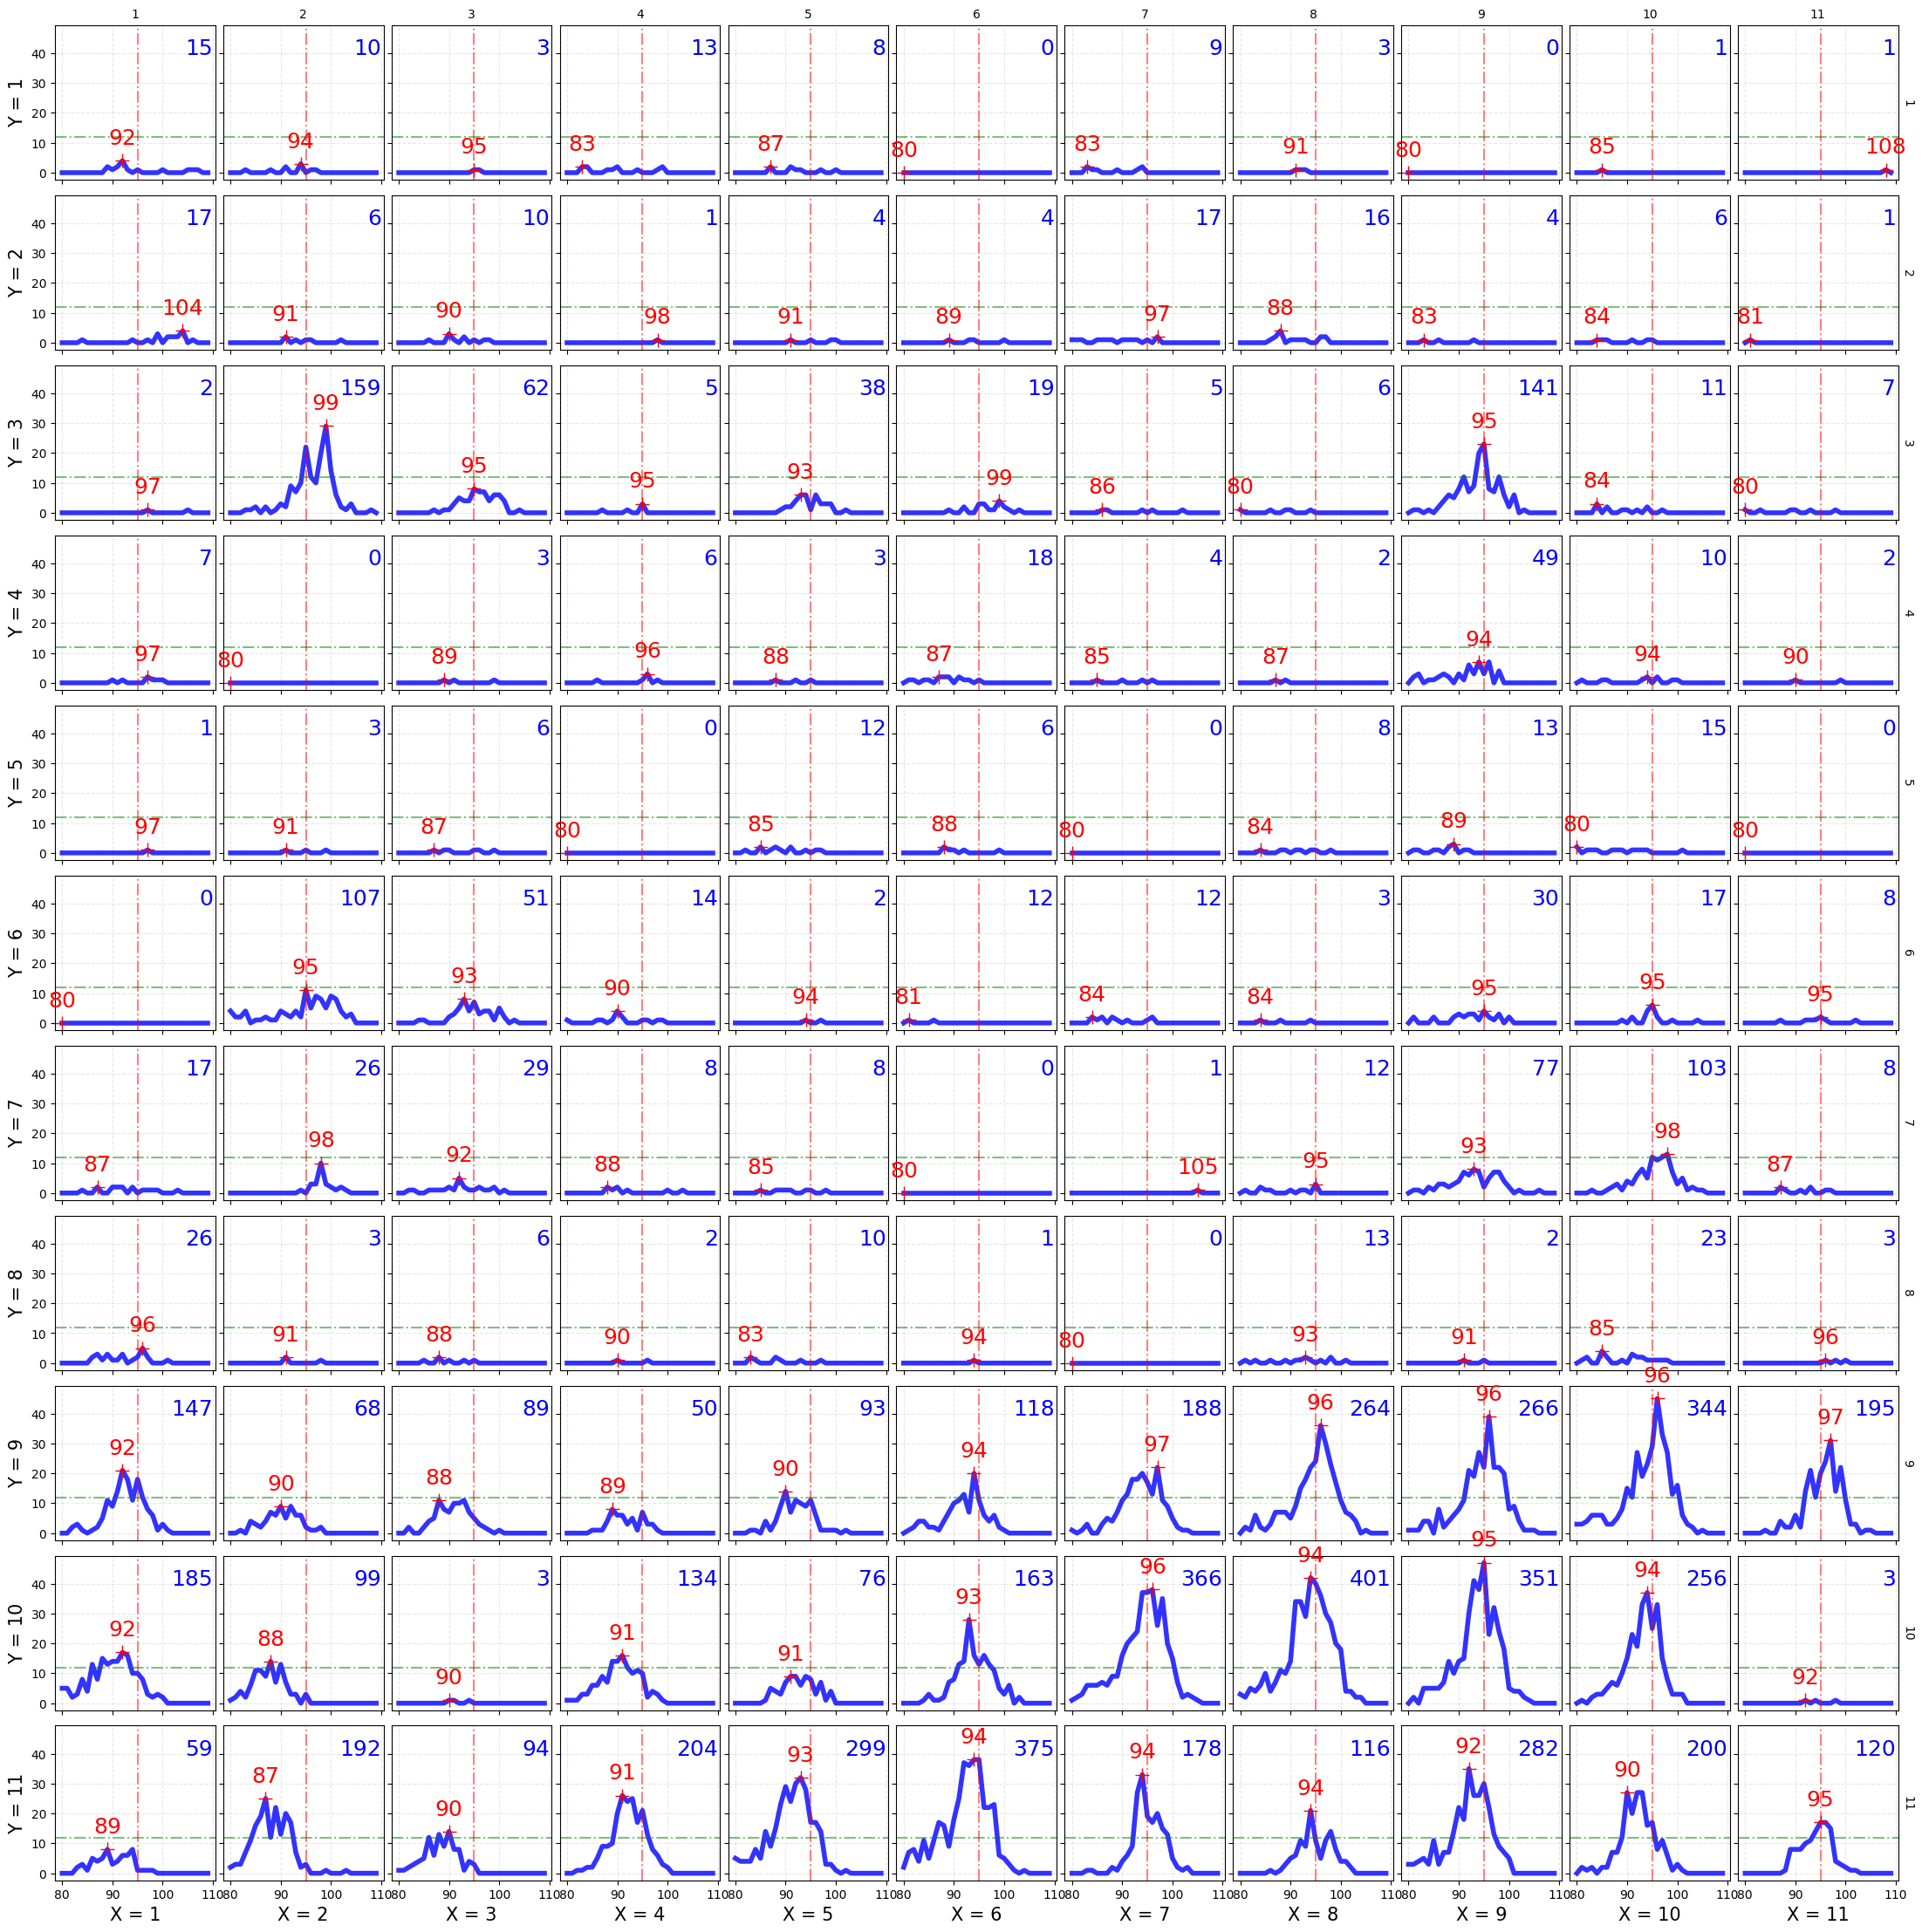

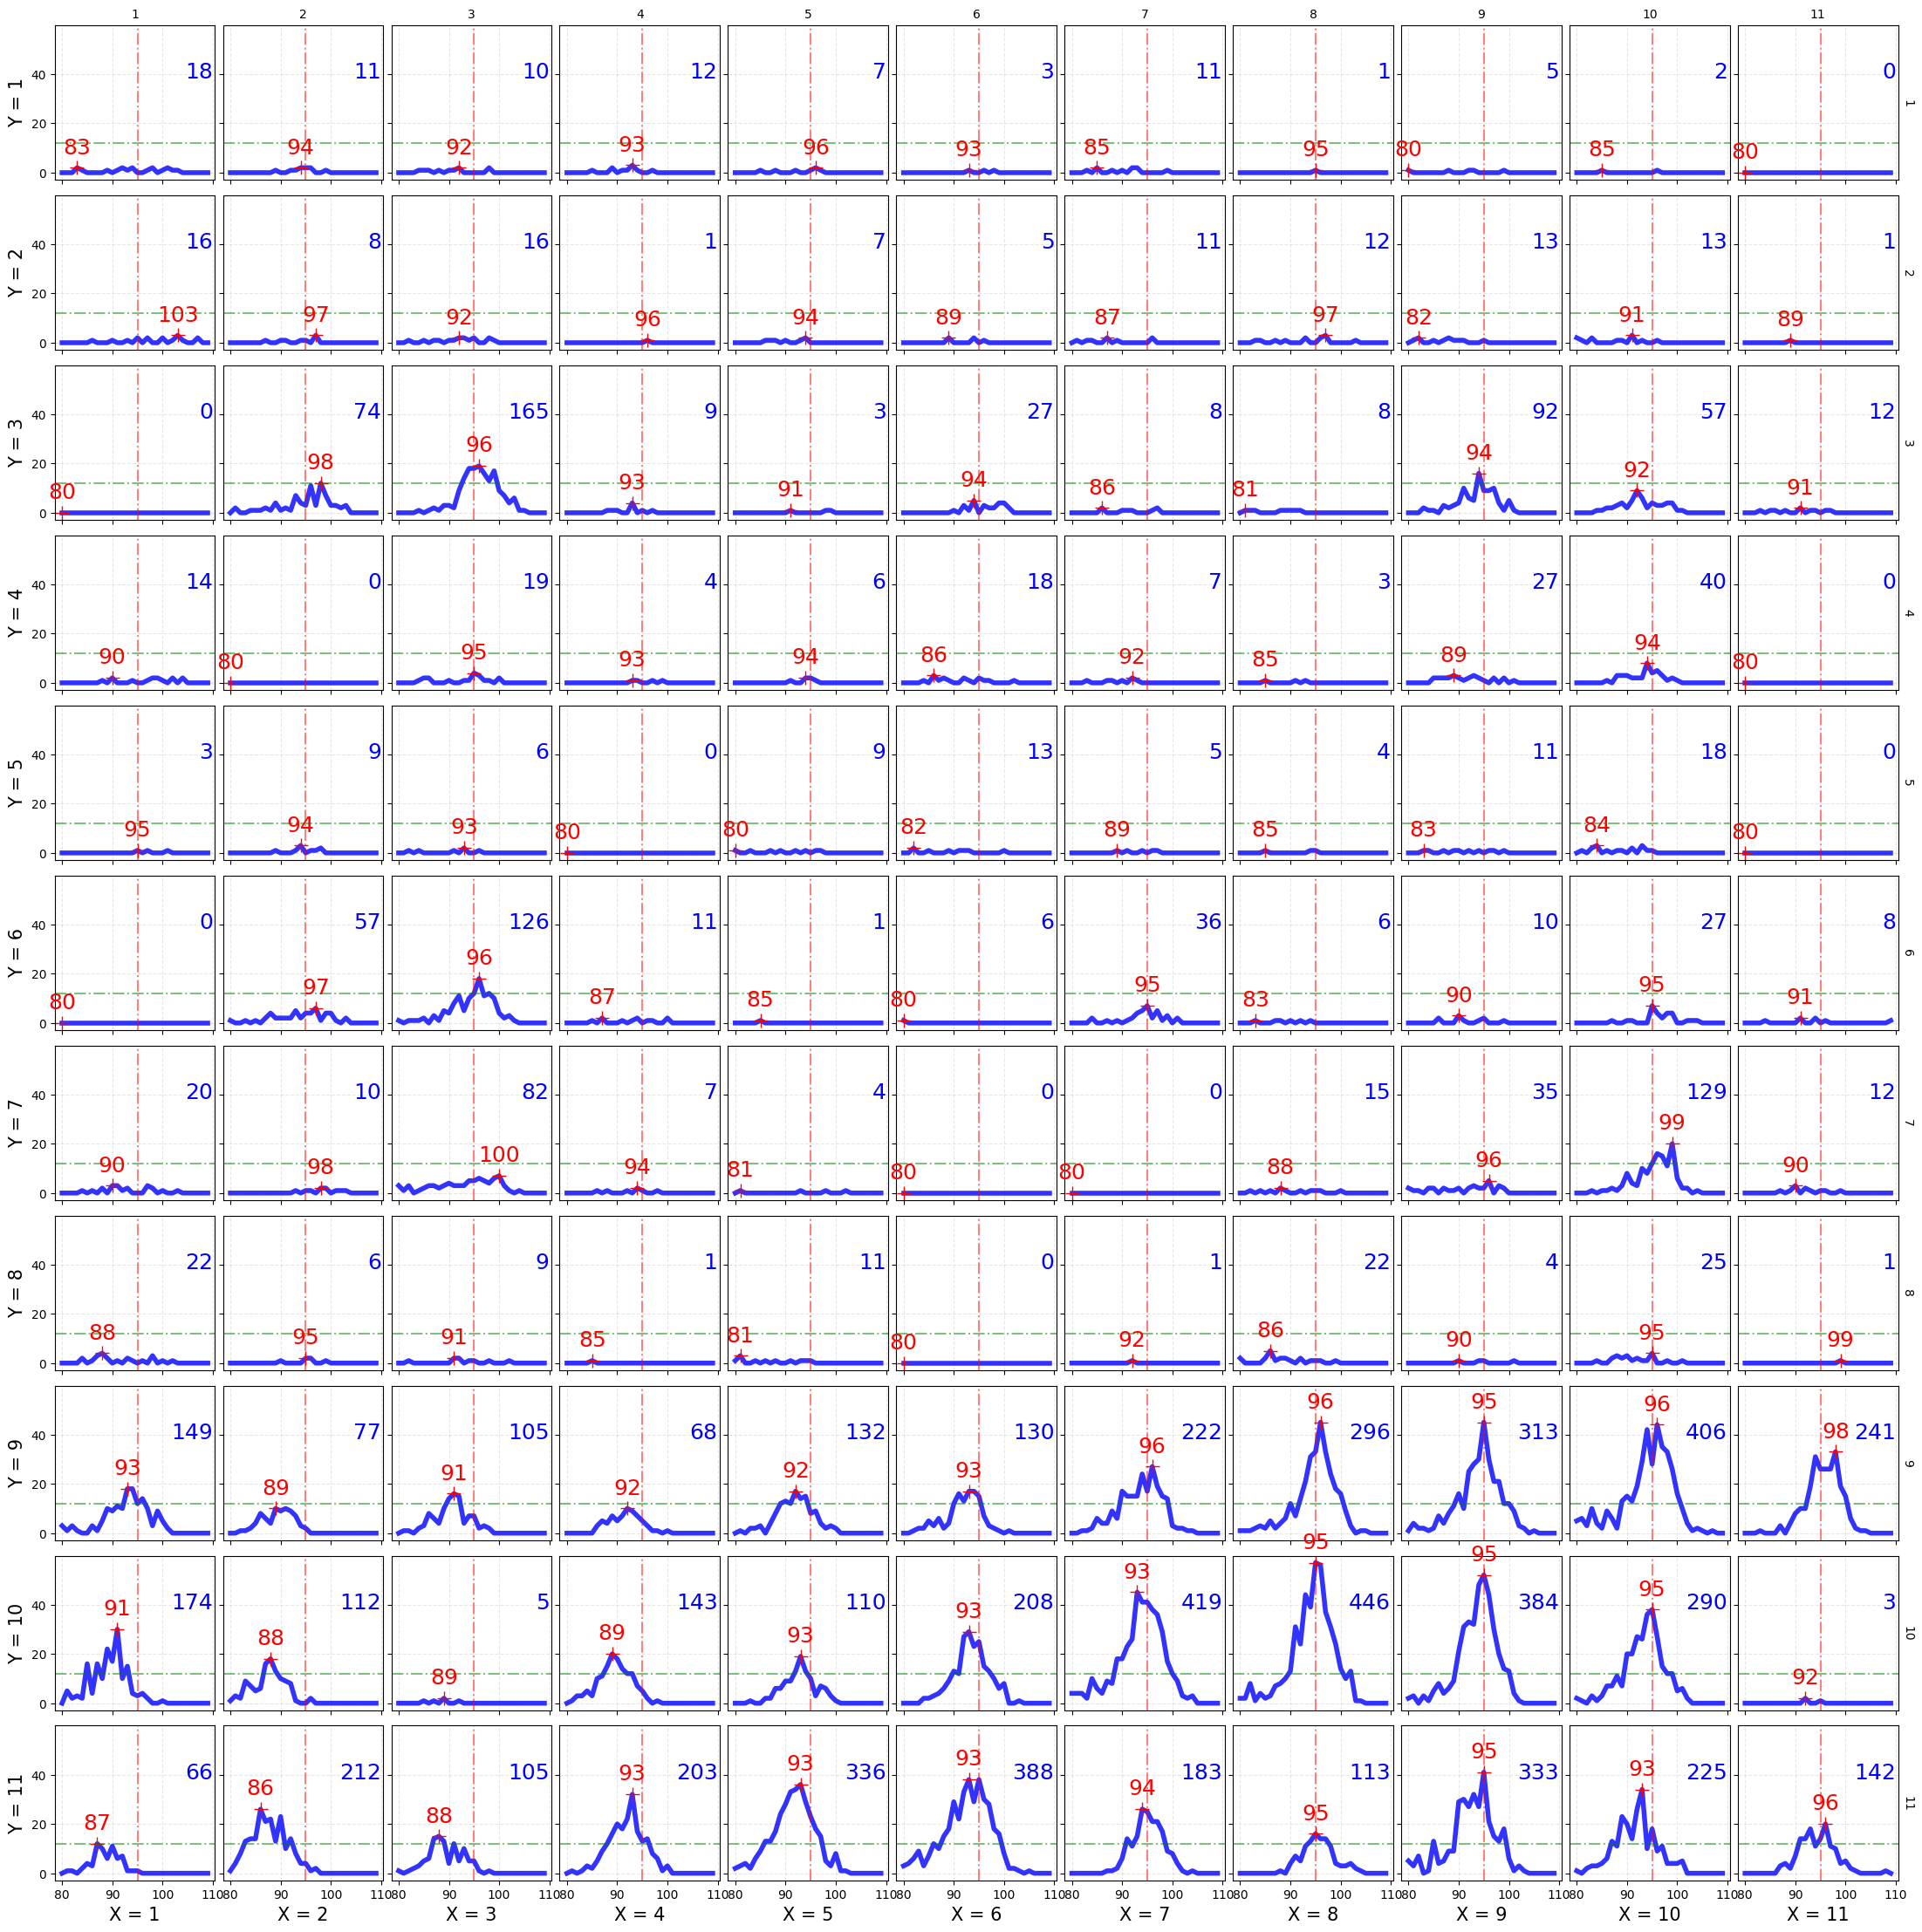

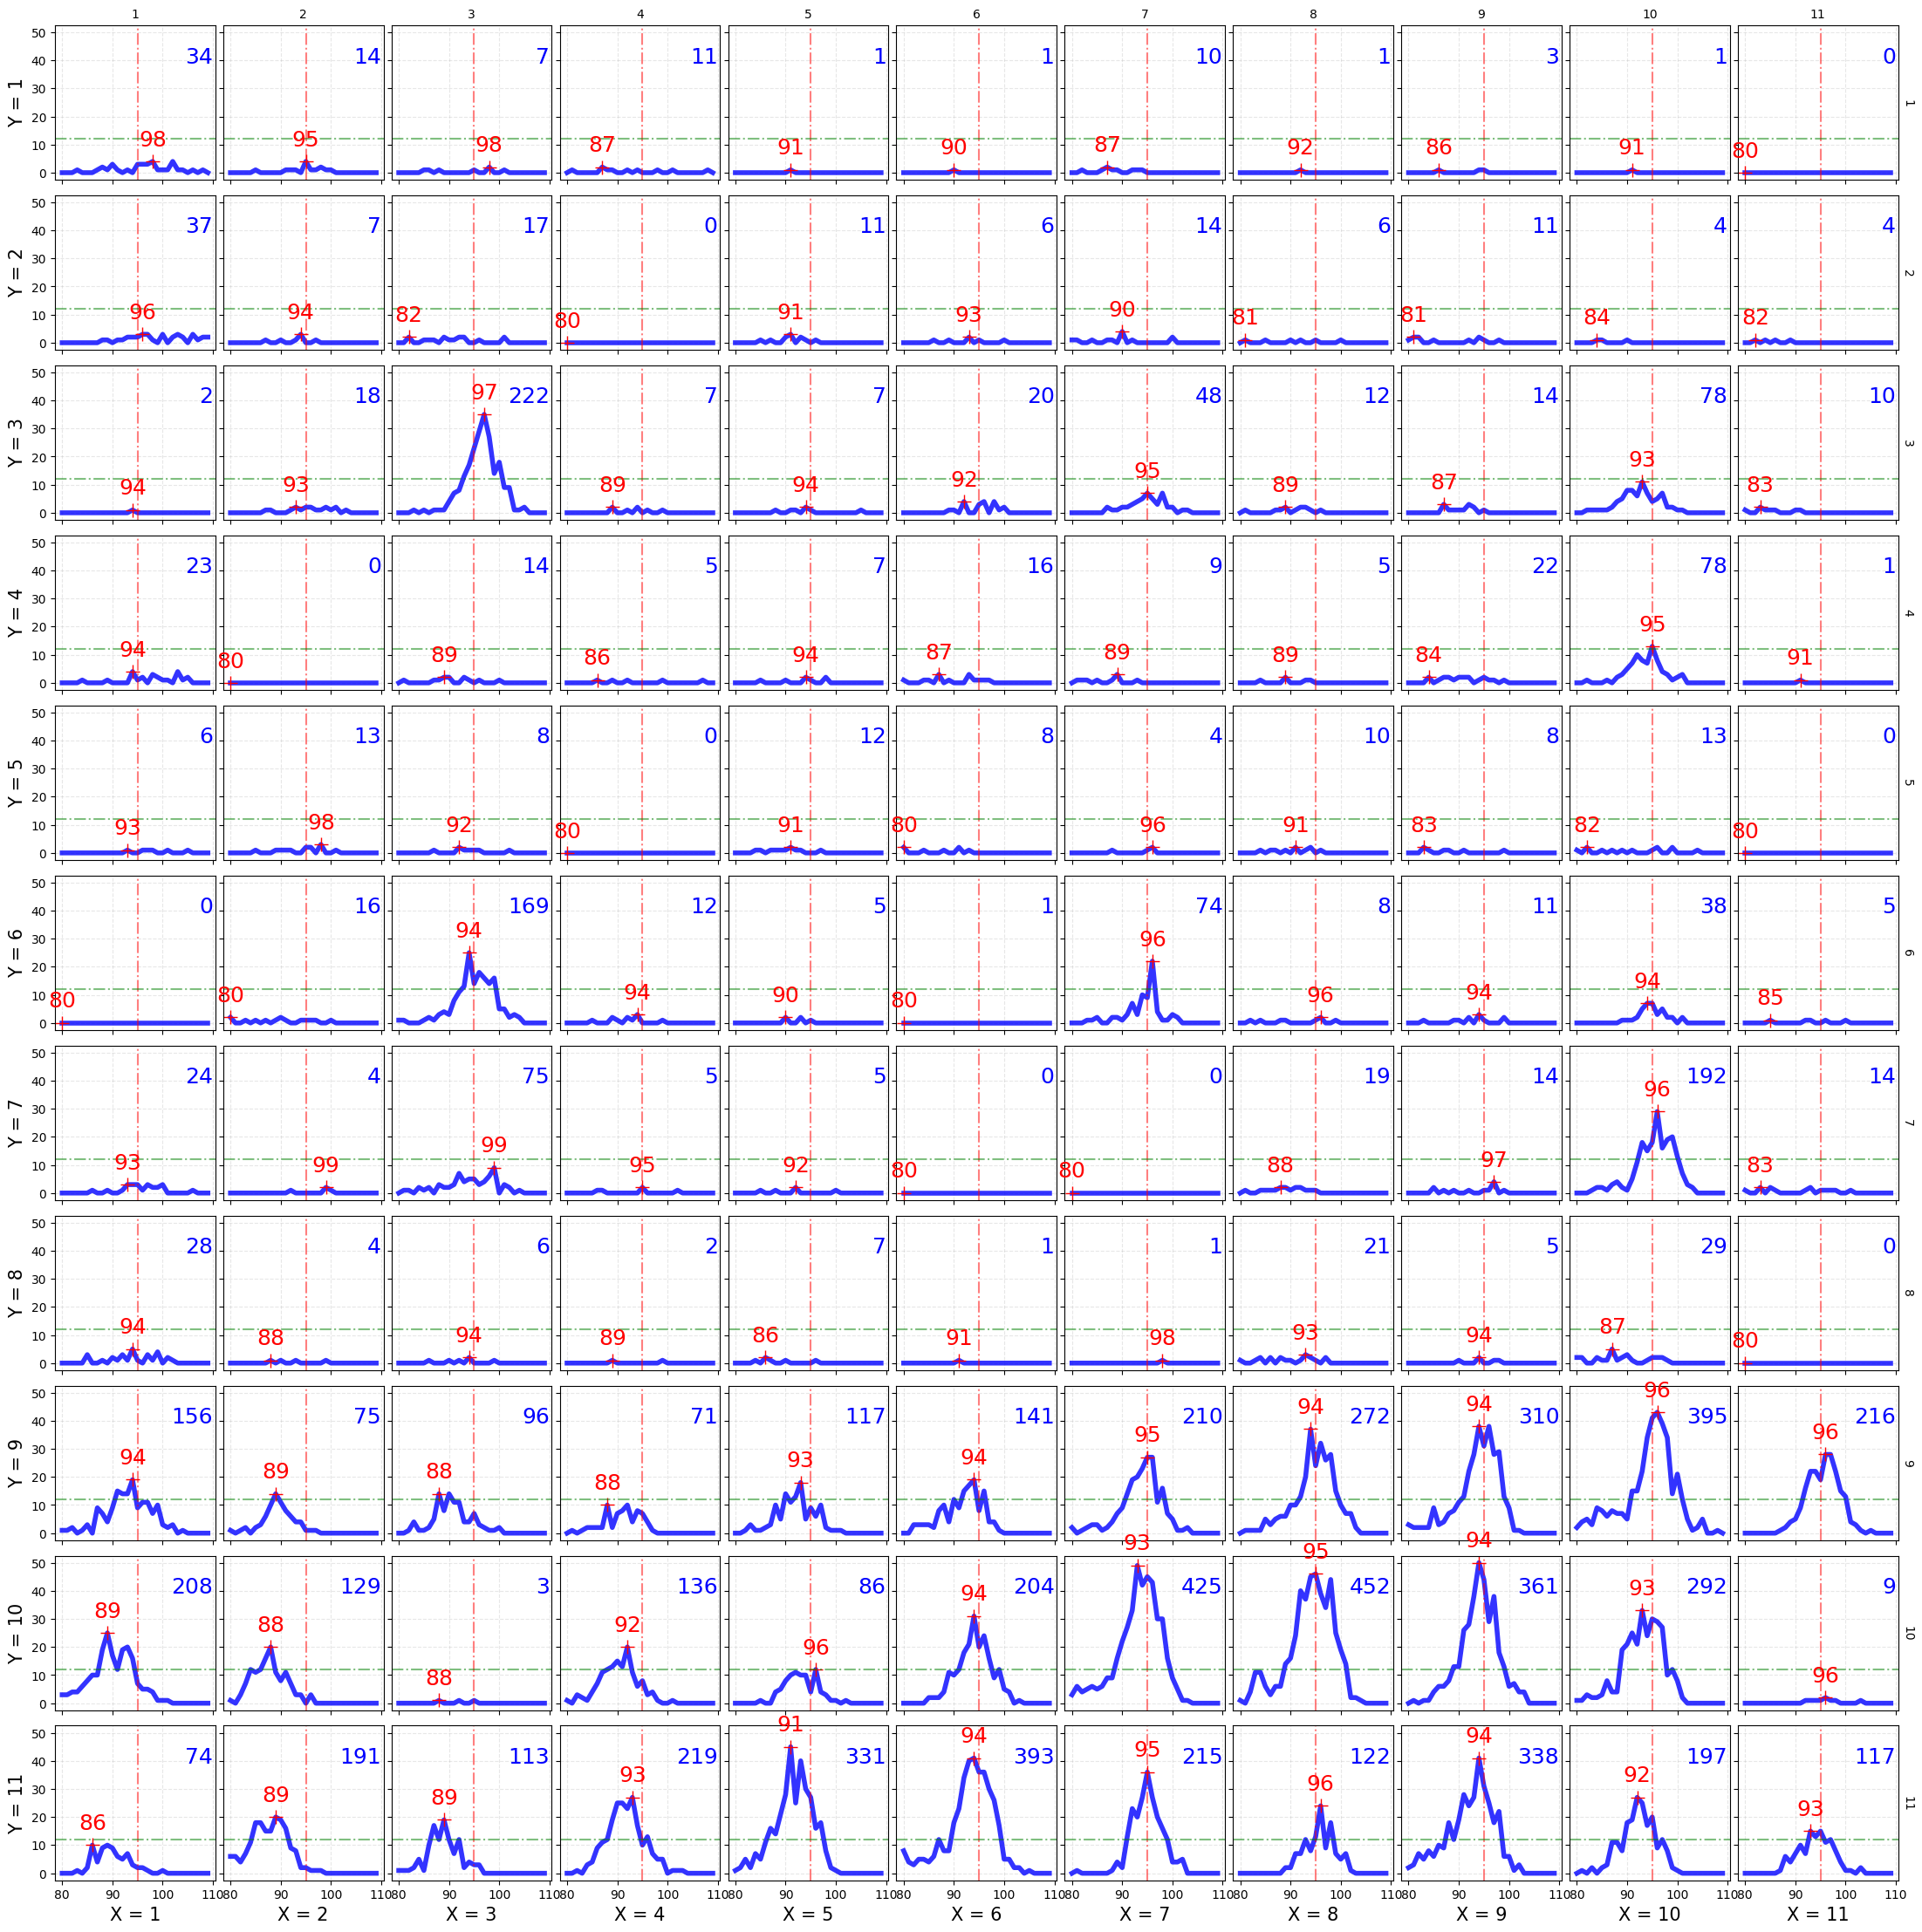

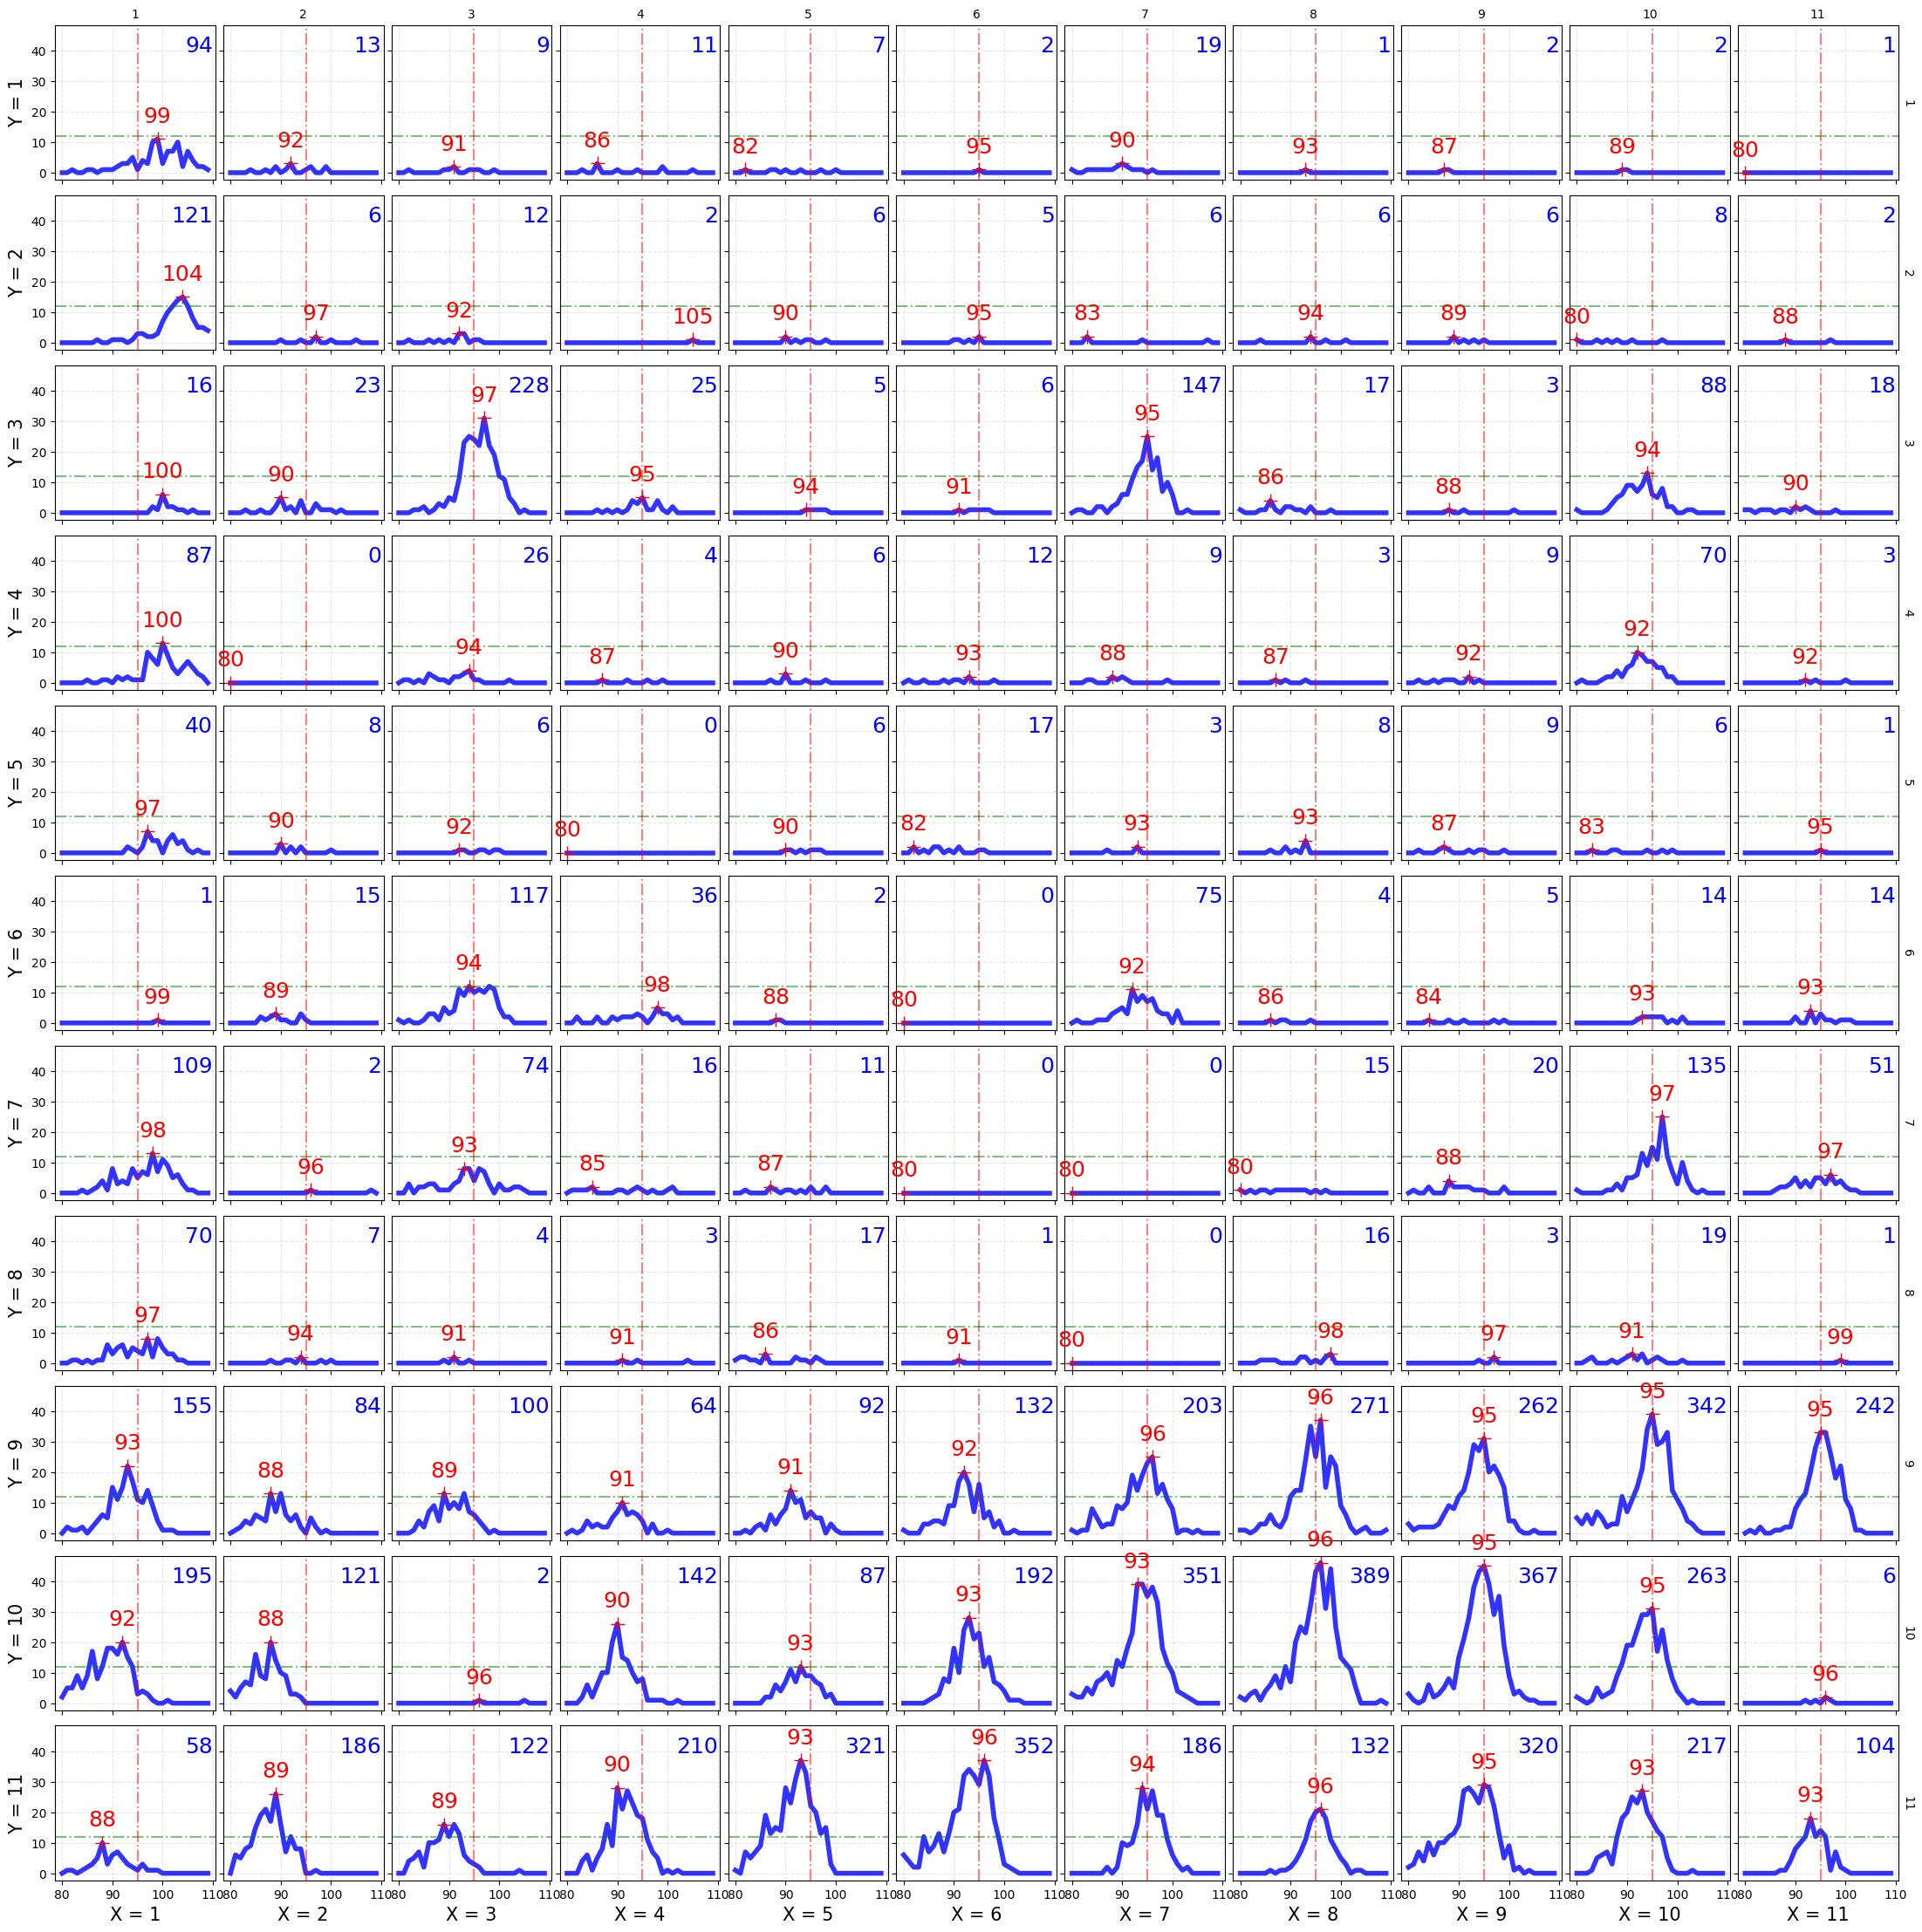

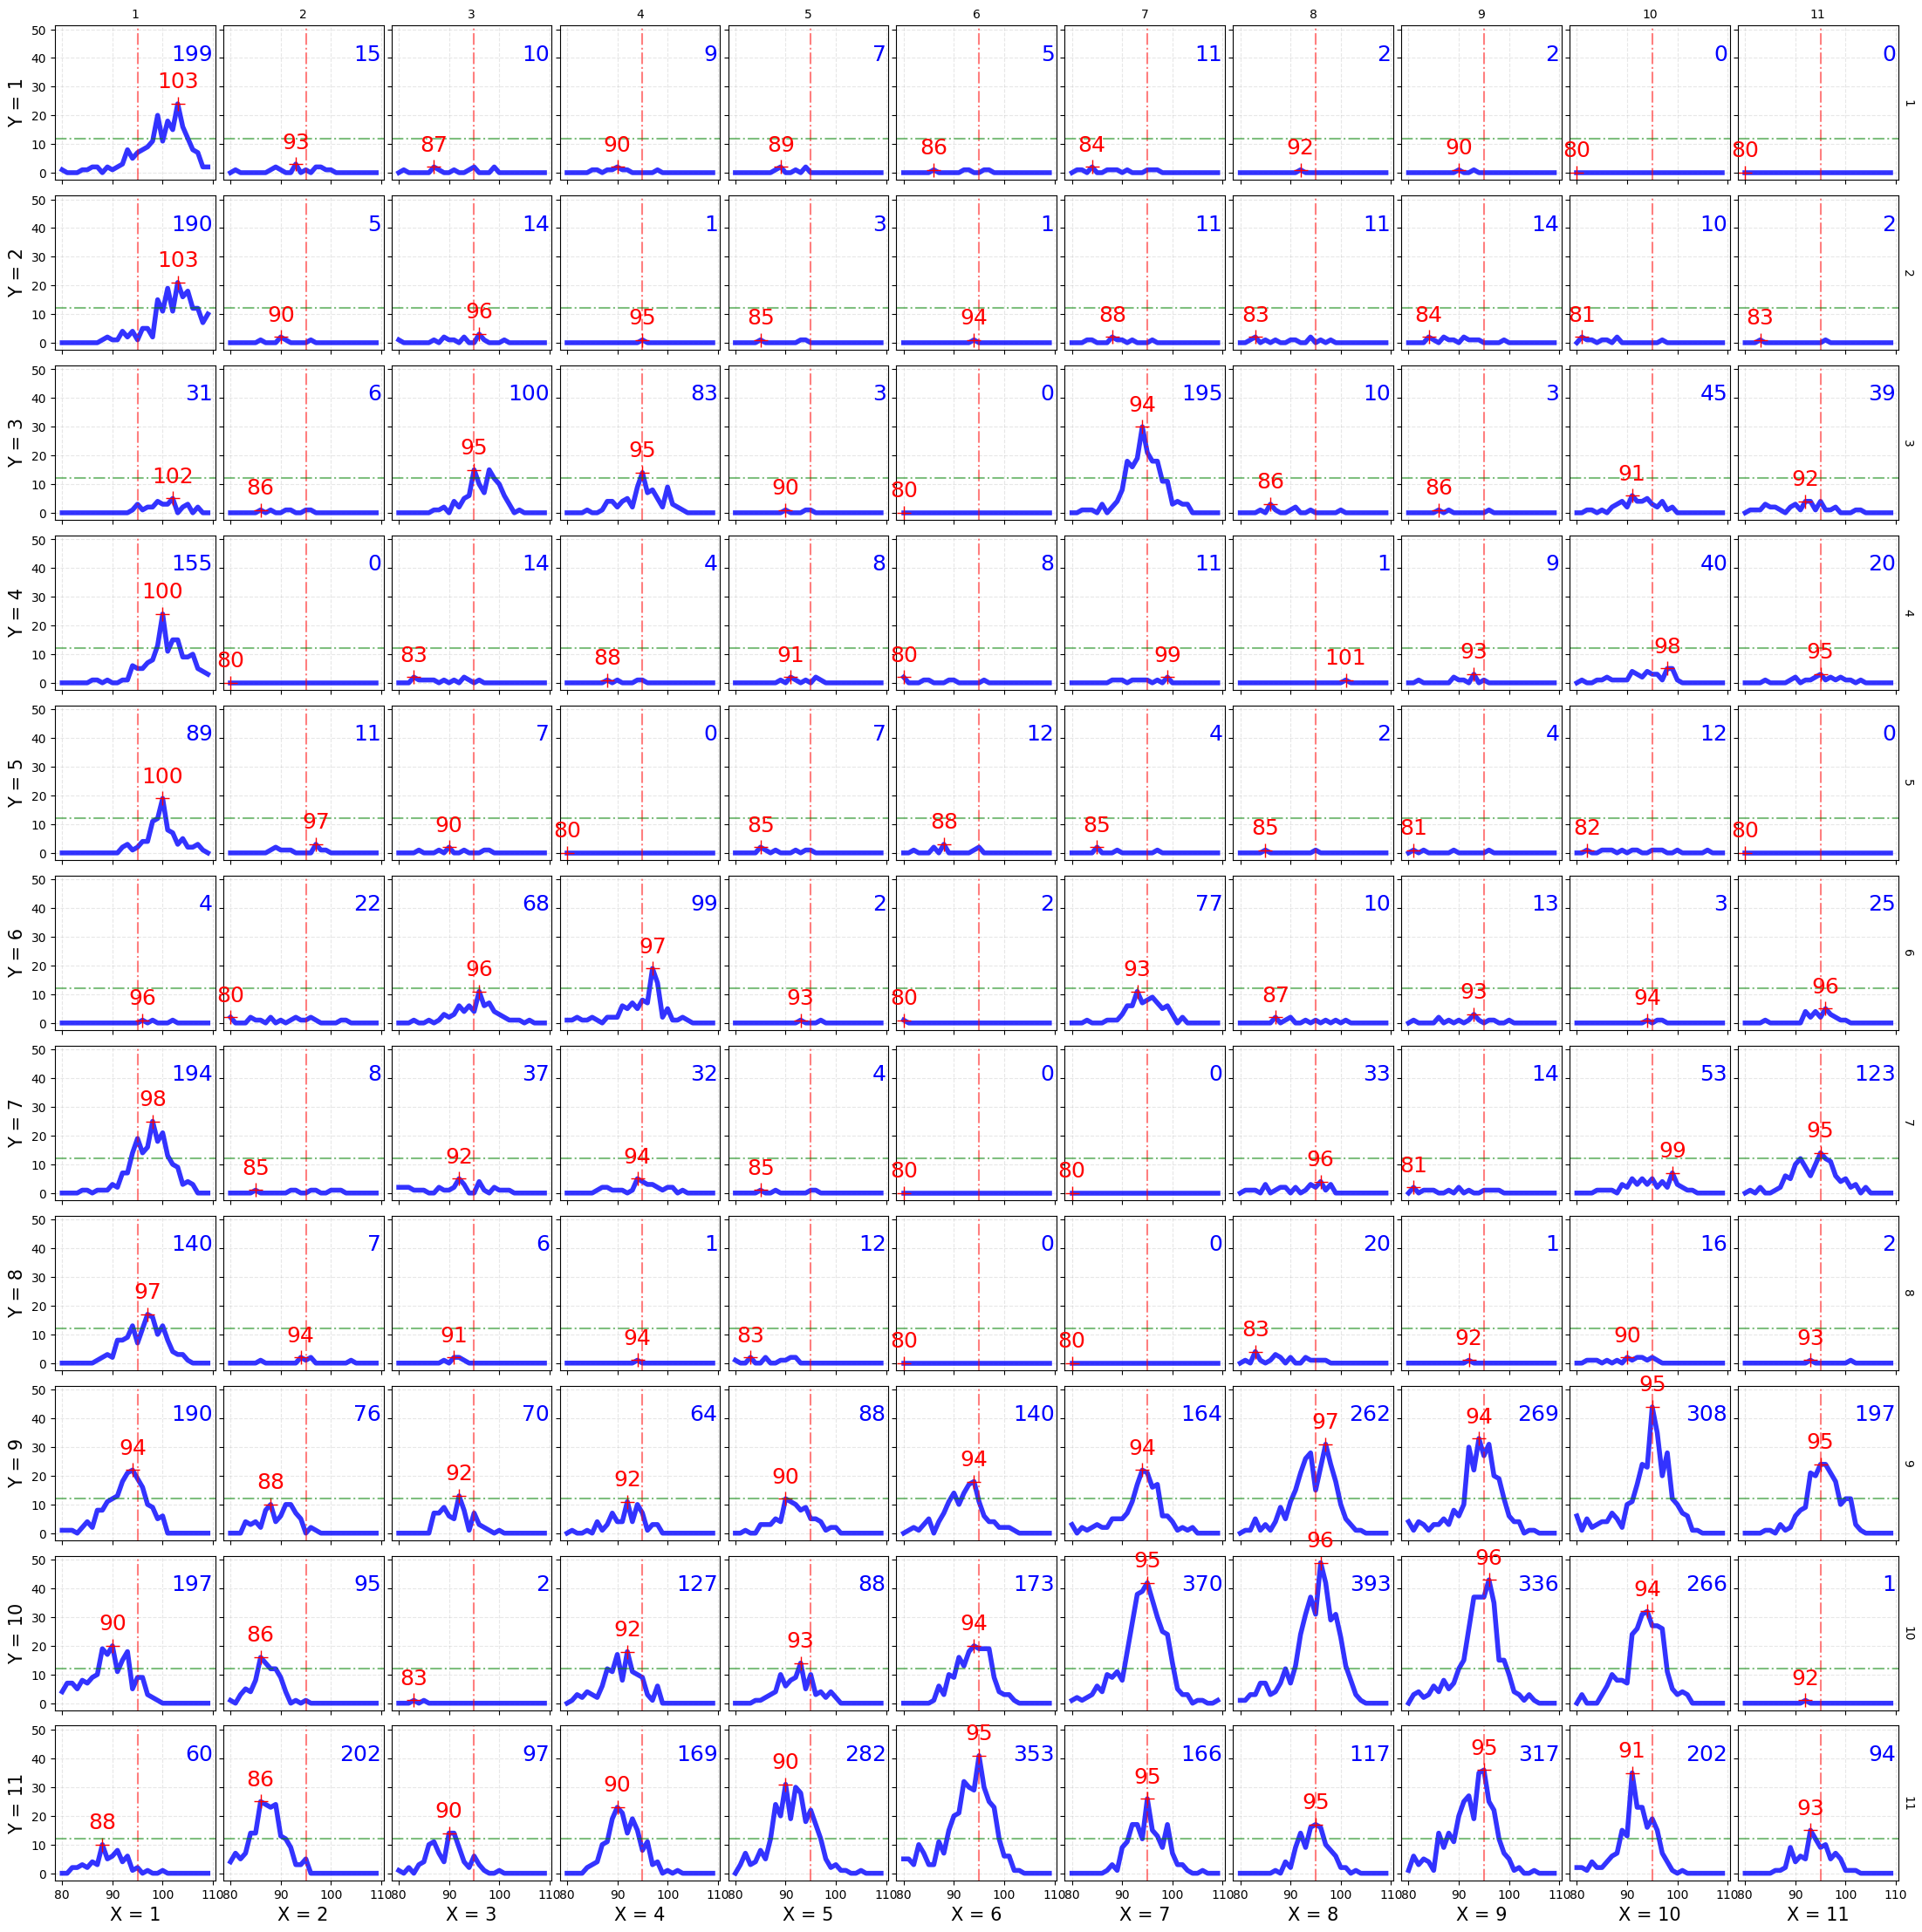

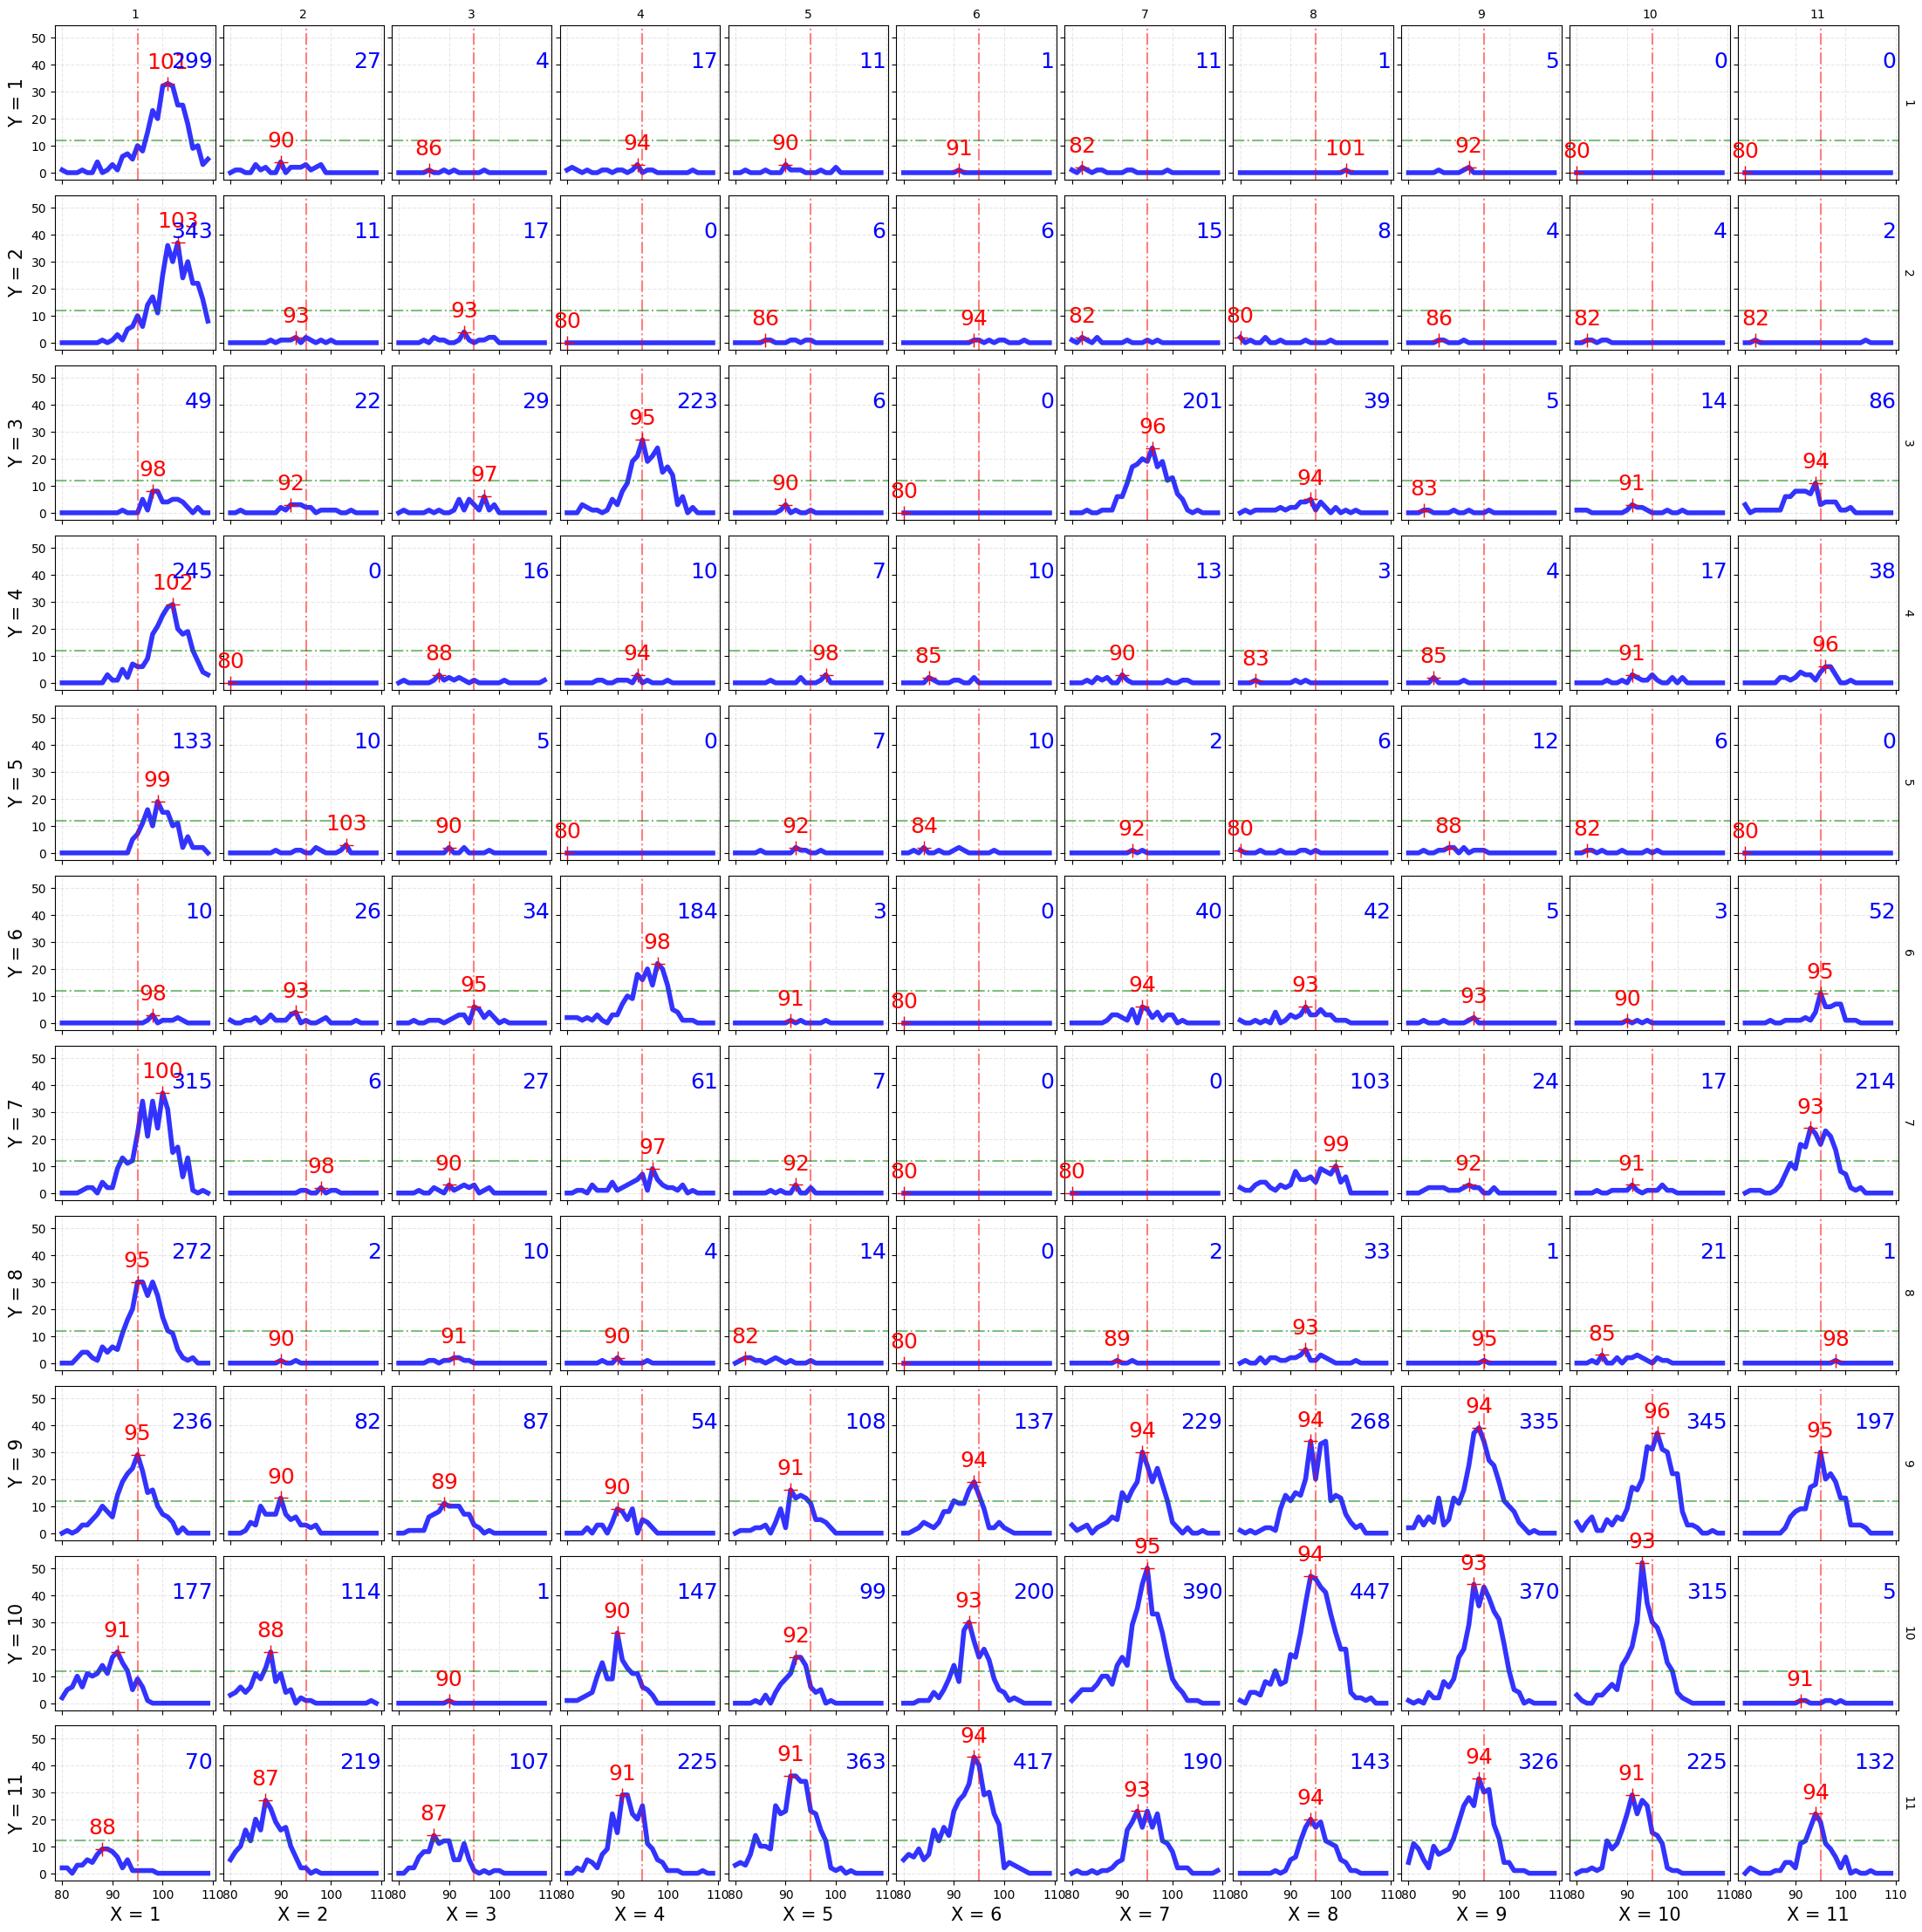

In [141]:
save_folder = r"C:\Users\10552\OneDrive - Redlen Technologies\Code\spectrum-analyzer\grid_plots"

for i, df in enumerate(df_transformed_list):
    grid = spectrum_grid_plot(df, min_range=80, max_range=110, vline_pos=95, hline_pos=12)
    print(f"Saving grid plot {i}")
    output_file = os.path.join(save_folder, f"grid_plot_{i}.png")
    grid.savefig(output_file, dpi=80)
    
# 3 min 41 sec for 10 grid plots
# about 21 seconds per grid plot